This notebook contains an mPDF analysis of the DMS data (all three compositions) taken on NOMAD in May 2015.

In [1]:
### Import a bunch of stuff.
import scipy
from scipy import interpolate
from scipy.optimize.minpack import curve_fit
import numpy as np
import matplotlib.pyplot as plt
import sys
import random
import lmfit ## important note: I had to install ipywidgets to get lmfit to work inside the ipython environment
from lmfit import Parameters, minimize, fit_report
from mcalculator_mod import calculateMPDF, cv, j0calc, costransform

%matplotlib notebook

C:\Users\benfr\Anaconda\lib\site-packages\IPython\html.py:14: ShimWarning: The `IPython.html` package has been deprecated. You should import from `notebook` instead. `IPython.html.widgets` has moved to `ipywidgets`.
  "`IPython.html.widgets` has moved to `ipywidgets`.", ShimWarning)


In [2]:
### Define lots of modules
def fitfunc(x,lowerb,upperb,scale1,scale2,theta,phi,width,damp,rSr,Sr,para):
    '''
    x: meaningless array, can be simply np.array([0]), just needed to make the curve_fit module work
    scale1: scale factor of the correlated part of d(r) (coming from the ideal mPDF)
    scale2: scale factor of the "paramagnetic" part of d(r)
    width: smoothing factor when calculating the mPDF
    theta, phi: angles giving direction of "up"-spin in the cubic coordinate system
    damp: full-width half max of overall gaussian envelope applied to mPDF.
    '''
    svec = np.array([np.sin(theta)*np.cos(phi),np.sin(theta)*np.sin(phi),np.cos(theta)])
    svec=S*svec
    spins[:]=svec
    [r,fr]=calculateMPDF(atoms,spins,uclist,rstep,rcalcmax,width) ### ideal f(r)
    rDr,Dr = cv(r,fr,rSr,Sr) ### correlated term in d(r)
    Dr = scale1*Dr
    Dr[:len(para)] += scale2*para ### adding paramagnetic term
    th=(np.sin(qmax*r)-np.sin(qmin*r))/np.pi/r ### convolution to simulate effects of finite qmin and qmax
    rDrcv, Drcv = cv(rDr,Dr,r,th)
    dampf=np.exp(-(rDrcv/2.0/damp)**2)
    Drcv=dampf*Drcv
    #rDrcv, Drcv = rDr,Dr
    return Drcv[np.logical_and(rDrcv>lowerb+0.5*rstep,rDrcv<=upperb+0.5*rstep)]

def residual(pars, x, data=None):
    vals = pars.valuesdict()
    scalePara=vals['scalePara']
    scaleCorr=vals['scaleCorr']
    width=vals['width']
    damp=vals['damp']
    theta=vals['theta']
    phi=vals['phi']

    para = -1.0*np.sqrt(2.0*np.pi)*np.gradient(Sr,rSr[1]-rSr[0]) ### paramagnetic term in d(r)

    model = fitfunc(x,rmin,rmax,scaleCorr,scalePara,theta,phi,width,damp,rSr,Sr,para)
    if data is None:
        return model
    return (model - data)

def PDFdiffGrabber(inName,outName,scale=1.0):
    '''
    inName = file name of the .fgr exported fit file from PDFgui
    outName = desired file name for the experimental mPDF (just the difference curve from the calculated structural PDF)
    scale = float giving refined scale factor from PDFgui for normalization purposes
    '''
    allcols = np.loadtxt(inName,unpack=True,comments='#',skiprows=14)
    r,diff=allcols[0],allcols[4]
    np.savetxt(outName,np.transpose((r,diff/scale)))
    
def getRlat(a,b,c):
    return 2*np.pi*np.cross(b,c)/(np.dot(a,np.cross(b,c))),2*np.pi*np.cross(c,a)/(np.dot(b,np.cross(c,a))),2*np.pi*np.cross(a,b)/(np.dot(c,np.cross(a,b)))

First, I will do the mPDF refinements for the x=0.2,y=0.15 data set.

In [3]:
### Extract and save the experimental mPDF from the exported PDF fit file
inPrefix='x02y015/mPDF/exportedPDFfits/I4mmm_0-20_'
inSuffix='K.fgr'
outPrefix='x02y015/mPDF/exportedPDFfits/I4mmm_0-20_'
outSuffix='_scaleNorm.diff'
tempStrings=['002','050','100','130','150','200','250','300']

temps,scaleFactors=np.loadtxt('x02y015/mPDF/exportedPDFfits/qmax31lorch_I4mmm_Tscan_scale.dat',unpack=True)

for i in range(len(tempStrings)):
    PDFdiffGrabber(inPrefix+tempStrings[i]+inSuffix,outPrefix+tempStrings[i]+outSuffix,scale=scaleFactors[i])

In [4]:
### Set some important values for calculation and structure
rstep=0.01
rmin=0.5 # rmin and rmax set the data range for the fit
rmax=18.5
rcalcmin = 0 # The calculation is extended slightly beyond the fit range to avoid artifacts at boundaries.
rcalcmax=20

qmin,qmax=0.0,31.41

[dq,q1,q2] = [0.01,0.00,10.00]
q=np.arange(q1,q2,dq)   
ffMag=j0calc(q,[0.422,17.684,0.5948,6.005,0.0043,-0.609,-0.0219]) ### magnetic form factor for Ni2+

r1,r2,dr=-5.0,5.0,0.01
rsr, sr=costransform(q,ffMag,rmin=r1,rmax=r2,rstep=dr)
sr = np.sqrt(np.pi/2.0)*sr

rSr,Sr = cv(rsr,sr,rsr,sr)

para = -1.0*np.sqrt(2.0*np.pi)*np.gradient(Sr,rSr[1]-rSr[0]) ### paramagnetic term in d(r)


Refining...
Results for 002K:
[[Variables]]
    scalePara:   0.37020927 +/- 0.061433 (16.59%) (init= 0.6159658)
    scaleCorr:   0.24276706 +/- 0.038024 (15.66%) (init= 0.510041)
    width:       0.2 (fixed)
    damp:        0.90309270 +/- 0.035535 (3.93%) (init= 20)
    theta:       0.28217268 +/- 0.087930 (31.16%) (init= 2.066272)
    phi:         1.56860128 +/- 2.27e+13 (1449131185868867.50%) (init=-2.267769)
[[Correlations]] (unreported correlations are <  0.100)
    C(scalePara, phi)            =  0.991 
    C(scaleCorr, damp)           = -0.933 
    C(scalePara, scaleCorr)      =  0.852 
    C(scalePara, damp)           = -0.850 
    C(scaleCorr, phi)            =  0.805 
    C(damp, phi)                 = -0.802 
    C(theta, phi)                = -0.604 
    C(scalePara, theta)          = -0.558 
    C(damp, theta)               =  0.182 
Final refined spin: [  6.11193990e-04   2.78442395e-01   9.60452737e-01]

0.0551985033155


C:\Users\benfr\Anaconda\lib\site-packages\ipykernel\__main__.py:55: DeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


<IPython.core.display.Javascript object>


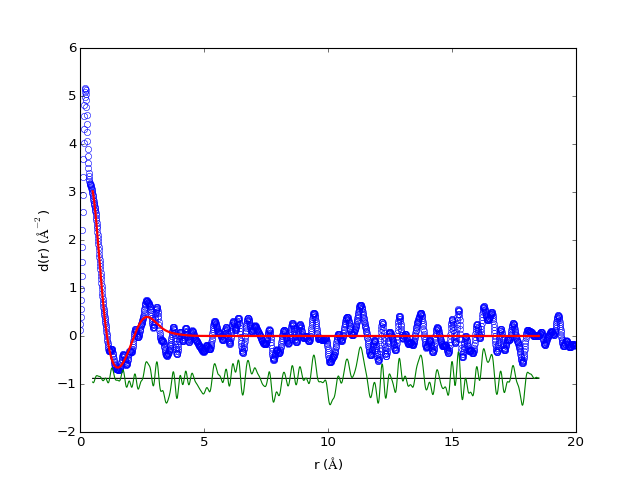

Refining...
Results for 050K:
[[Variables]]
    scalePara:   0.35302481 +/- 0.040410 (11.45%) (init= 0.2806722)
    scaleCorr:   0.22991488 +/- 0.034256 (14.90%) (init= 0.7695983)
    width:       0.2 (fixed)
    damp:        0.90748689 +/- 0.029973 (3.30%) (init= 20)
    theta:       0.29458502 +/- 0.118999 (40.40%) (init= 0.7327384)
    phi:        -1.68320949 +/- 5.26e+11 (31223732120112.19%) (init=-0.4053585)
[[Correlations]] (unreported correlations are <  0.100)
    C(scalePara, phi)            =  0.979 
    C(scaleCorr, theta)          =  0.952 
    C(scaleCorr, damp)           = -0.899 
    C(scalePara, theta)          =  0.835 
    C(scalePara, scaleCorr)      =  0.828 
    C(damp, theta)               = -0.814 
    C(theta, phi)                =  0.806 
    C(scaleCorr, phi)            =  0.752 
    C(scalePara, damp)           = -0.748 
    C(damp, phi)                 = -0.654 
Final refined spin: [-0.03256966 -0.28851021  0.95692271]

0.0562043753035


<IPython.core.display.Javascript object>


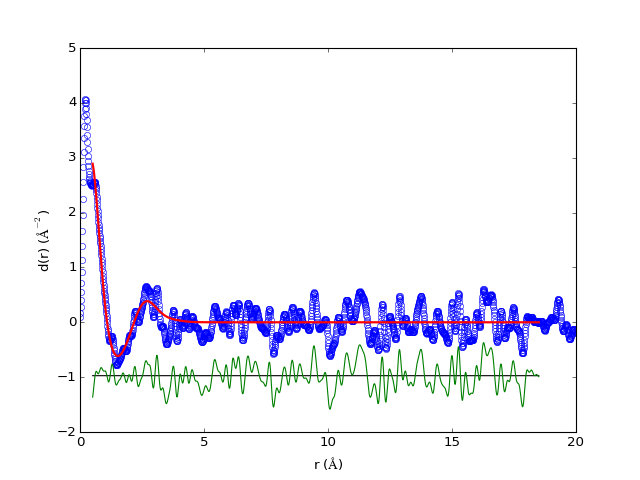

Refining...
Results for 100K:
[[Variables]]
    scalePara:   0.32696278 +/- 0.016737 (5.12%) (init= 0.4961254)
    scaleCorr:   0.20944461 +/- 0.040630 (19.40%) (init= 0.6685589)
    width:       0.2 (fixed)
    damp:        0.91785790 +/- 0.048618 (5.30%) (init= 20)
    theta:       2.84561005 +/- 0.119293 (4.19%) (init= 2.103763)
    phi:        -2.86082784 +/- 9.23e+12 (322518923691941.19%) (init= 3.129305)
[[Correlations]] (unreported correlations are <  0.100)
    C(scaleCorr, damp)           = -0.956 
    C(scalePara, phi)            = -0.886 
    C(damp, phi)                 = -0.876 
    C(scaleCorr, phi)            =  0.859 
    C(scalePara, theta)          = -0.816 
    C(theta, phi)                =  0.804 
    C(scalePara, damp)           =  0.622 
    C(scalePara, scaleCorr)      = -0.599 
    C(damp, theta)               = -0.518 
    C(scaleCorr, theta)          =  0.421 
Final refined spin: [-0.28025878 -0.08082175 -0.956516  ]

0.0505777326059


<IPython.core.display.Javascript object>


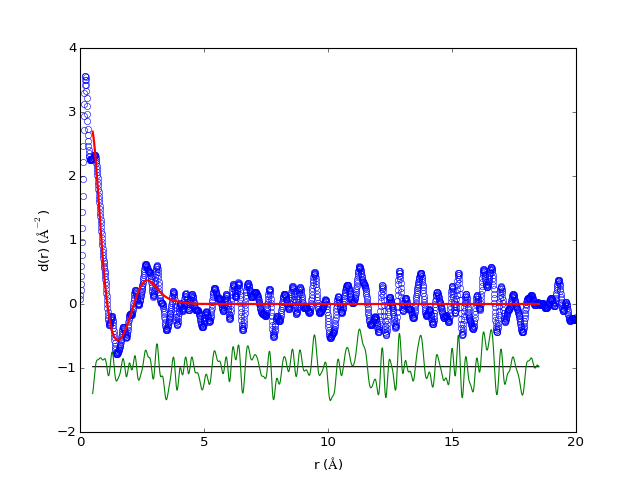

Refining...
Results for 130K:
[[Variables]]
    scalePara:   0.22710271 +/- 0.021364 (9.41%) (init= 0.2833987)
    scaleCorr:   0.12033867 +/- 0.031984 (26.58%) (init= 0.2720988)
    width:       0.2 (fixed)
    damp:        1.00985040 +/- 0.042362 (4.19%) (init= 20)
    theta:       0.20125866 +/- 0.169148 (84.05%) (init= 1.389744)
    phi:        -2.63835459 +/- 6.92e+12 (262456609773954.88%) (init=-3.122014)
[[Correlations]] (unreported correlations are <  0.100)
    C(scalePara, phi)            =  0.947 
    C(scaleCorr, phi)            = -0.876 
    C(scaleCorr, theta)          =  0.835 
    C(scaleCorr, damp)           = -0.793 
    C(damp, theta)               = -0.763 
    C(scalePara, scaleCorr)      = -0.727 
    C(theta, phi)                = -0.554 
    C(damp, phi)                 =  0.502 
    C(scalePara, theta)          = -0.434 
    C(scalePara, damp)           =  0.292 
Final refined spin: [-0.17511992 -0.09640604  0.97981574]

0.0481817346412


<IPython.core.display.Javascript object>


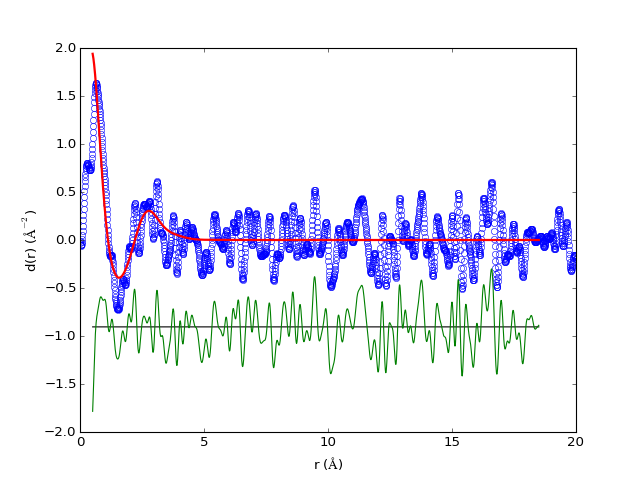

Refining...
Results for 150K:
[[Variables]]
    scalePara:   0.30371608 +/- 0.032741 (10.78%) (init= 0.3765344)
    scaleCorr:   0.19498693 +/- 0.032864 (16.85%) (init= 0.3999468)
    width:       0.2 (fixed)
    damp:        0.92659180 +/- 0.024412 (2.63%) (init= 20)
    theta:       0.30970213 +/- 0.186575 (60.24%) (init= 0.8841872)
    phi:         3.09652326 +/- 1.83e+12 (59187093026467.10%) (init= 1.149636)
[[Correlations]] (unreported correlations are <  0.100)
    C(scalePara, phi)            = -0.974 
    C(scaleCorr, theta)          =  0.937 
    C(theta, phi)                =  0.929 
    C(scalePara, theta)          = -0.874 
    C(scaleCorr, phi)            =  0.796 
    C(scalePara, scaleCorr)      = -0.683 
    C(scaleCorr, damp)           = -0.482 
    C(damp, theta)               = -0.220 
    C(scalePara, damp)           = -0.178 
Final refined spin: [-0.30446547  0.01373137  0.95242439]

0.0472208811121


<IPython.core.display.Javascript object>


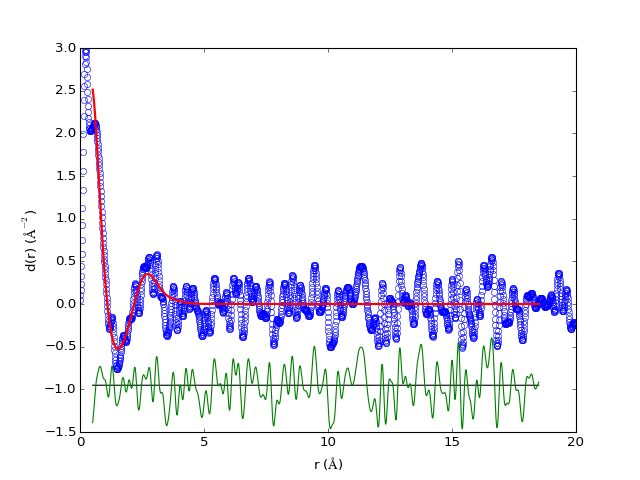

Refining...
Results for 200K:
[[Variables]]
    scalePara:   0.29133259 +/- 0.076081 (26.12%) (init= 0.4353255)
    scaleCorr:   0.18910287 +/- 0.018776 (9.93%) (init= 0.06239809)
    width:       0.2 (fixed)
    damp:        0.92579070 +/- 0.023828 (2.57%) (init= 20)
    theta:       0.31635834 +/- 0.149241 (47.17%) (init= 2.734016)
    phi:         2.96228727 +/- 3.55e+12 (119940296500101.52%) (init=-0.9747161)
[[Correlations]] (unreported correlations are <  0.100)
    C(scalePara, phi)            = -0.996 
    C(scalePara, theta)          =  0.912 
    C(theta, phi)                = -0.901 
    C(scaleCorr, damp)           = -0.789 
    C(scaleCorr, theta)          =  0.499 
    C(scalePara, scaleCorr)      =  0.194 
    C(damp, phi)                 = -0.163 
    C(damp, theta)               = -0.134 
    C(scaleCorr, phi)            = -0.134 
    C(scalePara, damp)           =  0.101 
Final refined spin: [-0.30611996  0.05548485  0.95037466]

0.0405201034068


<IPython.core.display.Javascript object>


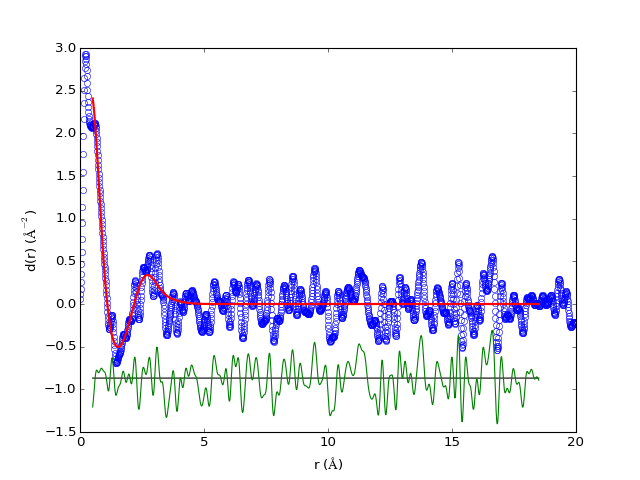

Refining...
Results for 250K:
[[Variables]]
    scalePara:   0.30026210 +/- 0.104803 (34.90%) (init= 0.1833224)
    scaleCorr:   0.20270389 +/- 0.061484 (30.33%) (init= 0.166077)
    width:       0.2 (fixed)
    damp:        0.90902247 +/- 0.055802 (6.14%) (init= 20)
    theta:       2.81009829 +/- 0.264393 (9.41%) (init= 2.595806)
    phi:         2.85411914 +/- 7.05e+12 (246926537323520.50%) (init=-2.748305)
[[Correlations]] (unreported correlations are <  0.100)
    C(scalePara, phi)            =  0.998 
    C(scaleCorr, damp)           = -0.975 
    C(theta, phi)                =  0.975 
    C(scalePara, theta)          =  0.968 
    C(scalePara, scaleCorr)      =  0.962 
    C(scaleCorr, phi)            =  0.951 
    C(scalePara, damp)           = -0.937 
    C(damp, phi)                 = -0.921 
    C(scaleCorr, theta)          =  0.866 
    C(damp, theta)               = -0.842 
Final refined spin: [-0.31210073  0.09227675 -0.94555705]

0.0379627838104


<IPython.core.display.Javascript object>


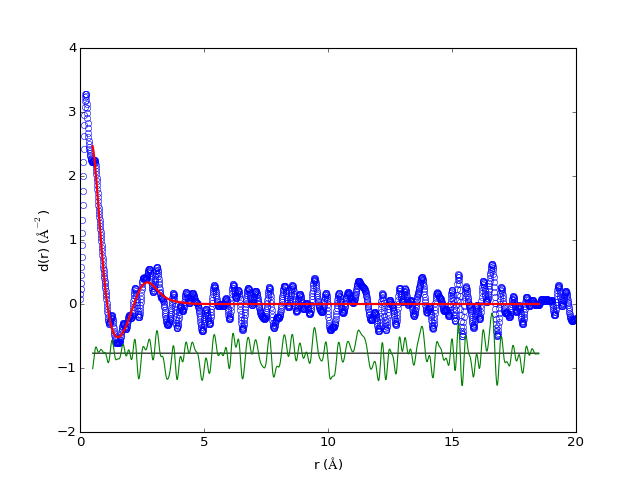

Refining...
Results for 300K:
[[Variables]]
    scalePara:   0.27837194 +/- 0.011047 (3.97%) (init= 0.00218643)
    scaleCorr:   0.18956866 +/- 0.020549 (10.84%) (init= 0.47574)
    width:       0.2 (fixed)
    damp:        0.91110341 +/- 0.022330 (2.45%) (init= 20)
    theta:       2.80042989 +/- 0.070197 (2.51%) (init= 0.9381493)
    phi:        -0.50428666 +/- 5.48e+14 (108712975329966928.00%) (init=-2.992156)
[[Correlations]] (unreported correlations are <  0.100)
    C(scaleCorr, theta)          = -0.906 
    C(scalePara, phi)            = -0.813 
    C(scaleCorr, damp)           = -0.778 
    C(scalePara, scaleCorr)      =  0.725 
    C(scalePara, theta)          = -0.643 
    C(damp, theta)               =  0.594 
    C(theta, phi)                =  0.571 
    C(scalePara, damp)           = -0.482 
    C(scaleCorr, phi)            = -0.460 
    C(damp, phi)                 =  0.103 
Final refined spin: [ 0.29293395 -0.16166486 -0.94236626]

0.0345242912427


<IPython.core.display.Javascript object>


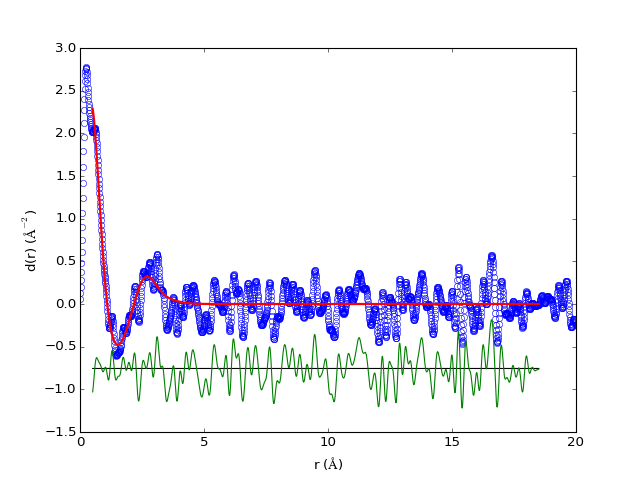

In [5]:
### Prepare the tetragonal structure for the calculations

### lattice parameters of magnetic unit cell, and some basis transformation stuff
e1=np.array([1,0,0])
e1n=e1/np.linalg.norm(e1)
e2=np.array([0,1,0])
e2n=e2/np.linalg.norm(e2)
e3=np.array([0,0,1])
e3n=e3/np.linalg.norm(e3)

temps,aVals=np.loadtxt('x02y015/mPDF/exportedPDFfits/qmax31lorch_I4mmm_Tscan_a-lat.dat',unpack=True)
temps,cVals=np.loadtxt('x02y015/mPDF/exportedPDFfits/qmax31lorch_I4mmm_Tscan_c-lat.dat',unpack=True)

Basis=np.array([e1,e2,e3])
IBasis=np.linalg.inv(Basis)
BasisN=np.array([e1n,e2n,e3n])

### positions of atoms in magnetic unit cell
basis=np.array([[0.5,0,0.75],[0,0.5,0.75],[0.5,0,0.25],[0,0.5,0.25]])

scaleParas=np.zeros_like(temps)
scaleCorrs=np.zeros_like(temps)
thetas=np.zeros_like(temps)
phis=np.zeros_like(temps)
damps=np.zeros_like(temps)
widths=np.zeros_like(temps)
chisqs=np.zeros_like(temps)
### loop through the temperatures to do the refinements
for i in [0,1,2,3,4,5,6,7]:
    a=aVals[i]
    b=aVals[i]
    c=cVals[i]    
    latpars=np.array([[a],[b],[c]])
    full=BasisN*latpars
    cell=np.dot(IBasis,full)
    atomcell=np.dot(basis,cell)
    
    ### spin orientations in same order as atomic positions.
    svec=np.array([0,0,1])
    svec=svec/np.linalg.norm(svec)
    svecmag=np.sqrt((svec*svec).sum())
    theta0=np.arccos(svec[2]/svecmag)
    phi0=np.arctan2(svec[1],svec[0])
    S=2.5
    spincell=S*np.array([svec,svec,svec,svec])


    ### how big to make the box
    radius=1.5*rcalcmax
    dim1=np.round(radius/np.linalg.norm(cell[0]))
    dim2=np.round(radius/np.linalg.norm(cell[1]))
    dim3=np.round(radius/np.linalg.norm(cell[2]))

    ### generate the coordinates of each unit cell 
    latos=np.dot(np.mgrid[-dim1:dim1+1,-dim2:dim2+1,-dim3:dim3+1].transpose().ravel().reshape((2*dim1+1)*(2*dim2+1)*(2*dim3+1),3),cell)

    ### select points within a desired radius from origin
    latos=latos[np.where(np.apply_along_axis(np.linalg.norm,1,latos)<=(rcalcmax+10.0))]

    ## rearrange latos array so that [0,0,0] is the first one (for convenience)
    latos[np.where(np.all(latos==[0,0,0],axis=1))]=latos[0]
    latos[0]=np.array([0,0,0])

    ### create list of all atomic positions and spin directions
    atoms=np.empty([len(latos)*len(atomcell),3])
    spins=np.empty([len(latos)*len(spincell),3])
    index=0
    for k in range(len(latos)):
        for j in range(len(atomcell)):
            atoms[index]=latos[k]+atomcell[j]
            spins[index] = spincell[j]
            index+=1

    ### Perform the calculations.

    uclist=np.array([0]) # indices of atoms which will be used as centers in the mPDF calculation
    x=np.array([0]) # empty array to be used as placeholder in the calculations

    dataFileName=outPrefix+tempStrings[i]+outSuffix
    expr,expDr = np.loadtxt(dataFileName,unpack=True) # grab the experimental data.

    print 'Refining...'

    fit_params = Parameters()
    fit_params.add('scalePara', value=np.random.uniform(0,1.0),min=0,max=20.0)#value=np.random.uniform(5,25),min=0,max=30)
    fit_params.add('scaleCorr', value=np.random.uniform(0,1.0),min=0.05,max=2.5)#value=np.random.uniform(5,25),min=0,max=30)
    fit_params.add('width', value=0.2,vary=False)
    fit_params.add('damp', value=20,min=0,max=100)
    fit_params.add('theta',value=np.arccos(np.random.uniform(-1,1)),min=0.000001,max=np.pi)#value=theta0,vary=False)# leave spins fixed for now
    fit_params.add('phi',value=np.random.uniform(-1.0*np.pi, np.pi),min=-1.0*np.pi,max=np.pi)#value=phi0,vary=False)

    data=expDr[np.logical_and(expr>rmin+0.5*rstep,expr<=rmax+0.5*rstep)]
    out = minimize(residual, fit_params, args=(x,), kws={'data':data})

    fit = residual(fit_params, x)
    print 'Results for '+tempStrings[i]+'K:'
    print fit_report(fit_params)

    refinedVals=fit_params.valuesdict()
    scaleCorr=refinedVals['scaleCorr']
    scalePara=refinedVals['scalePara']
    width=refinedVals['width']
    damp=refinedVals['damp']
    theta=refinedVals['theta']
    phi=refinedVals['phi']
    
    scaleCorrs[i]=scaleCorr
    scaleParas[i]=scalePara
    damps[i]=damp
    widths[i]=width
    thetas[i]=theta
    phis[i]=phi
    
    finalSpin=np.array([np.sin(theta)*np.cos(phi),np.sin(theta)*np.sin(phi),np.cos(theta)])
    print 'Final refined spin: '+str(finalSpin)+'\n'

    rcomp = expr[np.logical_and(expr>rmin+0.5*rstep,expr<=rmax+0.5*rstep)]
    diff = data-fit
    chisq=np.sum((diff)**2/len(diff))
    print chisq
    chisqs[i]=chisq
    
    spins[:]=S*finalSpin
    [r,fr]=calculateMPDF(atoms,spins,uclist,rstep,rcalcmax,width) ### ideal f(r)

    rfull=expr[np.logical_and(expr>rcalcmin+0.5*rstep,expr<=rcalcmax+0.5*rstep)]
    datafull=expDr[np.logical_and(expr>rcalcmin+0.5*rstep,expr<=rcalcmax+0.5*rstep)]
    compexpDr=expDr[np.logical_and(expr>rmin+0.5*rstep,expr<=rmax+0.5*rstep)]

    offset = 1.25*np.abs(np.min(data))

    fig=plt.figure()
    ax=fig.add_subplot(111)
    ax.plot(rfull,datafull,marker='o',mfc='none',mec='b',linestyle='none')
    ax.plot(rcomp,fit,'r-',lw=2)
    ax.plot(rcomp,np.zeros_like(rcomp)-offset,'k-',rcomp,diff-offset,'g-')
    #ax.plot(r,fr,'b-')
    ax.set_xlim(xmin=rcalcmin,xmax=rcalcmax)
    ax.set_xlabel('r ($\AA$)')
    ax.set_ylabel('d(r) ($\AA^{-2}$)')

    plt.show()

    ###### provide options to save data
    fitstring=' Experimental data: '+dataFileName+\
                '\n Chi-squared: '+str(chisq)+\
                '\n Correlated scale: '+str(scaleCorr)+\
                '\n Paramagnetic scale: '+str(scalePara)+\
                '\n Broadening factor: '+str(width)+\
                '\n Theta: '+str(theta)+\
                '\n Phi: '+str(phi)+\
                '\n Damp: '+str(damp)+\
                '\n '+\
                    '\n Column format: r, Obs., Calc., Diff.'
    savefile='x02y015/mPDF/mPDFfit_I4mmm_0-20_ferroFree_'+tempStrings[i]+'K_1.txt'
    np.savetxt(savefile,np.column_stack((rcomp,data,fit,diff)),header=fitstring)


In [9]:
plt.close('all')
#np.savetxt('scale_correlated.txt',np.transpose((temps,scaleCorrs)))

<IPython.core.display.Javascript object>


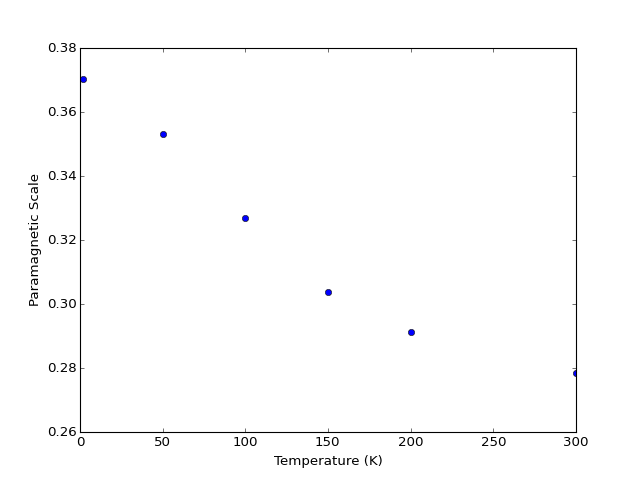

<IPython.core.display.Javascript object>


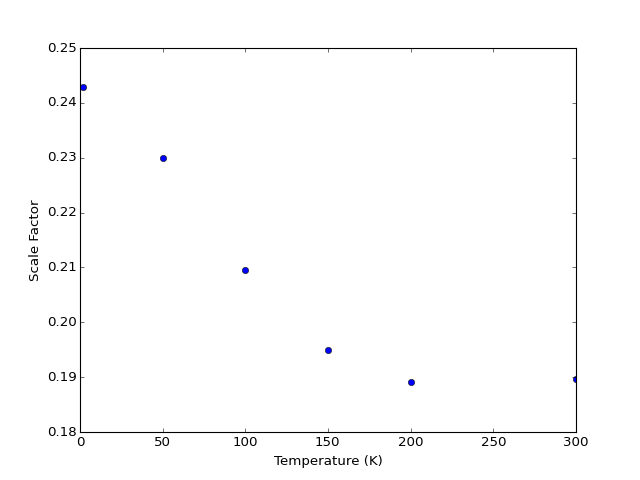

<IPython.core.display.Javascript object>


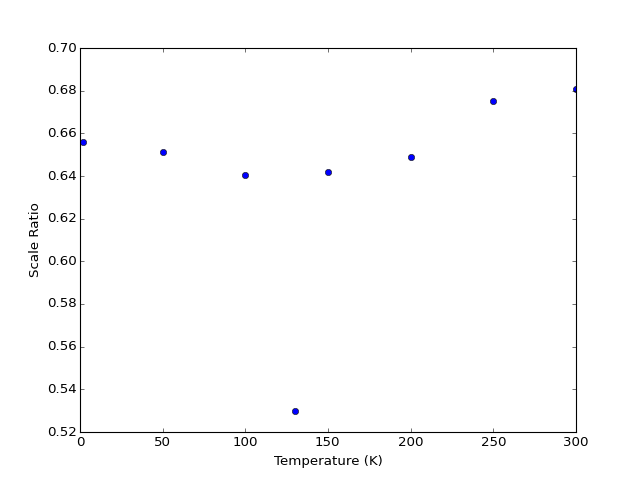

<IPython.core.display.Javascript object>


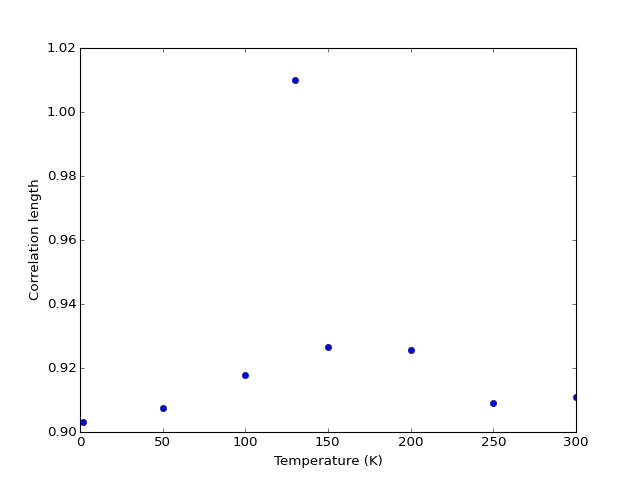

<IPython.core.display.Javascript object>


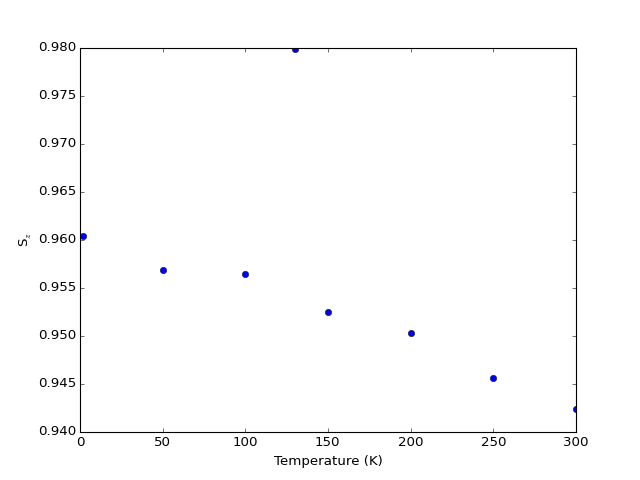

<IPython.core.display.Javascript object>


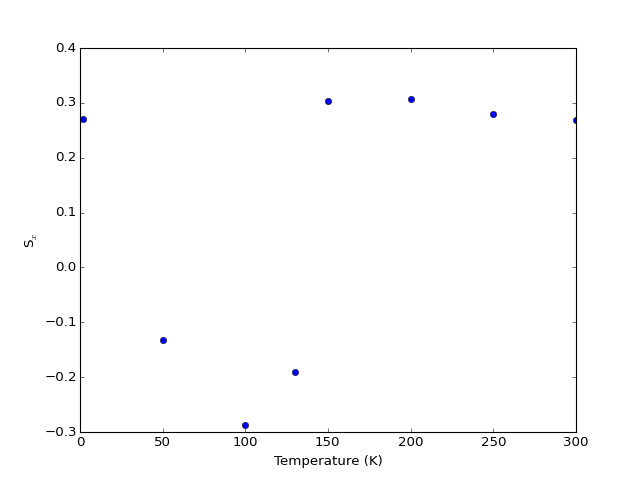

<IPython.core.display.Javascript object>


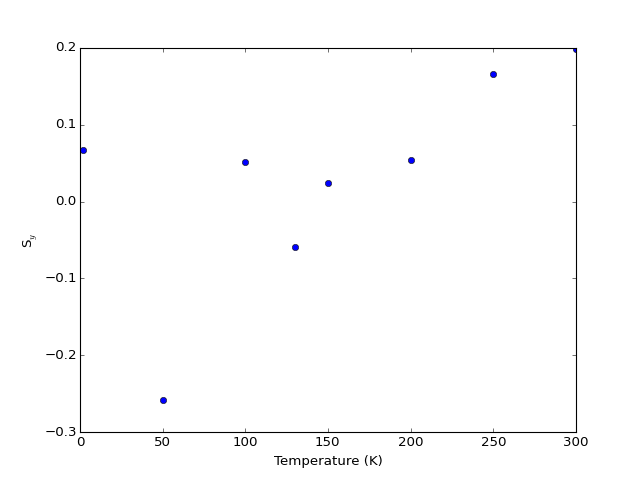

In [10]:
### Examine the temperature-dependent results a little more closely
goodidxs=np.array([0,1,2,4,5,7])
fig=plt.figure()
ax=fig.add_subplot(111)
ax.plot(temps[goodidxs],scaleParas[goodidxs],'bo')
ax.set_xlabel('Temperature (K)')
ax.set_ylabel('Paramagnetic Scale')

fig=plt.figure()
ax=fig.add_subplot(111)
ax.plot(temps[goodidxs],scaleCorrs[goodidxs],'bo')
ax.set_xlabel('Temperature (K)')
ax.set_ylabel('Scale Factor')

fig=plt.figure()
ax=fig.add_subplot(111)
ax.plot(temps,scaleCorrs/scaleParas,'bo')
ax.set_xlabel('Temperature (K)')
ax.set_ylabel('Scale Ratio')

fig=plt.figure()
ax=fig.add_subplot(111)
ax.plot(temps,damps,'bo')
ax.set_xlabel('Temperature (K)')
ax.set_ylabel('Correlation length')

Sxs=np.sin(thetas)*np.cos(phis)
Sys=np.sin(thetas)*np.sin(phis)
Szs=np.cos(thetas)
for i in range(len(Szs)):
    if Szs[i] < 0:
        Sxs[i]=-1.0*Sxs[i]
        Sys[i]=-1.0*Sys[i]
        Szs[i]=-1.0*Szs[i]

fig=plt.figure()
ax=fig.add_subplot(111)
ax.plot(temps,Szs,'bo')
ax.set_xlabel('Temperature (K)')
ax.set_ylabel('S$_z$')

fig=plt.figure()
ax=fig.add_subplot(111)
ax.plot(temps,Sxs,'bo')
ax.set_xlabel('Temperature (K)')
ax.set_ylabel('S$_x$')

fig=plt.figure()
ax=fig.add_subplot(111)
ax.plot(temps,Sys,'bo')
ax.set_xlabel('Temperature (K)')
ax.set_ylabel('S$_y$')

In [ ]:
plt.close('all')

Now I'll do the same analysis for the x=0.0, y=0.15 sample.

In [ ]:
### Extract and save the experimental mPDF from the exported PDF fit file
inPrefix='x00y015/mPDF/exportedPDFfits/I4mmm_0-20_'
inSuffix='K.fgr'
outPrefix='x00y015/mPDF/exportedPDFfits/I4mmm_0-20_'
outSuffix='_scaleNorm.diff'
tempStrings=['002','030','150','300']

temps,scaleFactors=np.loadtxt('x00y015/mPDF/exportedPDFfits/qmax31lorch_I4mmm_Tscan_scale.dat',unpack=True)

for i in range(len(tempStrings)):
    PDFdiffGrabber(inPrefix+tempStrings[i]+inSuffix,outPrefix+tempStrings[i]+outSuffix,scale=scaleFactors[i])

In [ ]:
### Set some important values for calculation and structure
rstep=0.01
rmin=0.2 # rmin and rmax set the data range for the fit
rmax=18.5
rcalcmin = 0 # The calculation is extended slightly beyond the fit range to avoid artifacts at boundaries.
rcalcmax=20

qmin,qmax=0.0,31.41

[dq,q1,q2] = [0.01,0.00,10.00]
q=np.arange(q1,q2,dq)   
ffMag=j0calc(q,[0.422,17.684,0.5948,6.005,0.0043,-0.609,-0.0219]) ### magnetic form factor for Ni2+

r1,r2,dr=-5.0,5.0,0.01
rsr, sr=costransform(q,ffMag,rmin=r1,rmax=r2,rstep=dr)
sr = np.sqrt(np.pi/2.0)*sr

rSr,Sr = cv(rsr,sr,rsr,sr)

para = -1.0*np.sqrt(2.0*np.pi)*np.gradient(Sr,rSr[1]-rSr[0]) ### paramagnetic term in d(r)


In [ ]:
### Prepare the tetragonal structure for the calculations

### lattice parameters of magnetic unit cell, and some basis transformation stuff
e1=np.array([1,0,0])
e1n=e1/np.linalg.norm(e1)
e2=np.array([0,1,0])
e2n=e2/np.linalg.norm(e2)
e3=np.array([0,0,1])
e3n=e3/np.linalg.norm(e3)

temps,aVals=np.loadtxt('x00y015/mPDF/exportedPDFfits/qmax31lorch_I4mmm_Tscan_a-lat.dat',unpack=True)
temps,cVals=np.loadtxt('x00y015/mPDF/exportedPDFfits/qmax31lorch_I4mmm_Tscan_c-lat.dat',unpack=True)

Basis=np.array([e1,e2,e3])
IBasis=np.linalg.inv(Basis)
BasisN=np.array([e1n,e2n,e3n])

### positions of atoms in magnetic unit cell
basis=np.array([[0.5,0,0.75],[0,0.5,0.75],[0.5,0,0.25],[0,0.5,0.25]])

scaleParas=np.zeros_like(temps)
scaleCorrs=np.zeros_like(temps)
thetas=np.zeros_like(temps)
phis=np.zeros_like(temps)
damps=np.zeros_like(temps)
widths=np.zeros_like(temps)
chisqs=np.zeros_like(temps)
### loop through the temperatures to do the refinements
for i in range(len(temps)):
    a=aVals[i]
    b=aVals[i]
    c=cVals[i]    
    latpars=np.array([[a],[b],[c]])
    full=BasisN*latpars
    cell=np.dot(IBasis,full)
    atomcell=np.dot(basis,cell)
    
    ### spin orientations in same order as atomic positions.
    svec=np.array([0,0,1])
    svec=svec/np.linalg.norm(svec)
    svecmag=np.sqrt((svec*svec).sum())
    theta0=np.arccos(svec[2]/svecmag)
    phi0=np.arctan2(svec[1],svec[0])
    S=2.5
    spincell=S*np.array([svec,svec,svec,svec])


    ### how big to make the box
    radius=1.5*rcalcmax
    dim1=np.round(radius/np.linalg.norm(cell[0]))
    dim2=np.round(radius/np.linalg.norm(cell[1]))
    dim3=np.round(radius/np.linalg.norm(cell[2]))

    ### generate the coordinates of each unit cell 
    latos=np.dot(np.mgrid[-dim1:dim1+1,-dim2:dim2+1,-dim3:dim3+1].transpose().ravel().reshape((2*dim1+1)*(2*dim2+1)*(2*dim3+1),3),cell)

    ### select points within a desired radius from origin
    latos=latos[np.where(np.apply_along_axis(np.linalg.norm,1,latos)<=(rcalcmax+10.0))]

    ## rearrange latos array so that [0,0,0] is the first one (for convenience)
    latos[np.where(np.all(latos==[0,0,0],axis=1))]=latos[0]
    latos[0]=np.array([0,0,0])

    ### create list of all atomic positions and spin directions
    atoms=np.empty([len(latos)*len(atomcell),3])
    spins=np.empty([len(latos)*len(spincell),3])
    index=0
    for k in range(len(latos)):
        for j in range(len(atomcell)):
            atoms[index]=latos[k]+atomcell[j]
            spins[index] = spincell[j]
            index+=1

    ### Perform the calculations.

    uclist=np.array([0]) # indices of atoms which will be used as centers in the mPDF calculation
    x=np.array([0]) # empty array to be used as placeholder in the calculations

    dataFileName=outPrefix+tempStrings[i]+outSuffix
    expr,expDr = np.loadtxt(dataFileName,unpack=True) # grab the experimental data.

    print 'Refining...'

    fit_params = Parameters()
    fit_params.add('scalePara', value=np.random.uniform(0,1.0),min=0,max=20.0)#value=np.random.uniform(5,25),min=0,max=30)
    fit_params.add('scaleCorr', value=np.random.uniform(0,1.0),min=0.05,max=2.5)#value=np.random.uniform(5,25),min=0,max=30)
    fit_params.add('width', value=0.2,vary=False)
    fit_params.add('damp', value=5,min=0,max=100)
    fit_params.add('theta',value=np.arccos(np.random.uniform(-1,1)),min=0.000001,max=np.pi)#value=theta0,vary=False)# leave spins fixed for now
    fit_params.add('phi',value=np.random.uniform(-1.0*np.pi, np.pi),min=-1.0*np.pi,max=np.pi)#value=phi0,vary=False)

    data=expDr[np.logical_and(expr>rmin+0.5*rstep,expr<=rmax+0.5*rstep)]
    out = minimize(residual, fit_params, args=(x,), kws={'data':data})

    fit = residual(fit_params, x)
    print 'Results for '+tempStrings[i]+'K:'
    print fit_report(fit_params)

    refinedVals=fit_params.valuesdict()
    scaleCorr=refinedVals['scaleCorr']
    scalePara=refinedVals['scalePara']
    width=refinedVals['width']
    damp=refinedVals['damp']
    theta=refinedVals['theta']
    phi=refinedVals['phi']
    
    scaleCorrs[i]=scaleCorr
    scaleParas[i]=scalePara
    damps[i]=damp
    widths[i]=width
    thetas[i]=theta
    phis[i]=phi
    
    finalSpin=np.array([np.sin(theta)*np.cos(phi),np.sin(theta)*np.sin(phi),np.cos(theta)])
    print 'Final refined spin: '+str(finalSpin)+'\n'

    rcomp = expr[np.logical_and(expr>rmin+0.5*rstep,expr<=rmax+0.5*rstep)]
    diff = data-fit
    chisq=np.sum((diff)**2/len(diff))
    print chisq
    chisqs[i]=chisq
    
    spins[:]=S*finalSpin
    [r,fr]=calculateMPDF(atoms,spins,uclist,rstep,rcalcmax,width) ### ideal f(r)

    rfull=expr[np.logical_and(expr>rcalcmin+0.5*rstep,expr<=rcalcmax+0.5*rstep)]
    datafull=expDr[np.logical_and(expr>rcalcmin+0.5*rstep,expr<=rcalcmax+0.5*rstep)]
    compexpDr=expDr[np.logical_and(expr>rmin+0.5*rstep,expr<=rmax+0.5*rstep)]

    offset = 1.25*np.abs(np.min(data))

    fig=plt.figure()
    ax=fig.add_subplot(111)
    ax.plot(rfull,datafull,marker='o',mfc='none',mec='b',linestyle='none')
    ax.plot(rcomp,fit,'r-',lw=2)
    ax.plot(rcomp,np.zeros_like(rcomp)-offset,'k-',rcomp,diff-offset,'g-')
    #ax.plot(r,fr,'b-')
    ax.set_xlim(xmin=rcalcmin,xmax=rcalcmax)
    ax.set_xlabel('r ($\AA$)')
    ax.set_ylabel('d(r) ($\AA^{-2}$)')

    #plt.show()

    ###### provide options to save data
    fitstring=' Experimental data: '+dataFileName+\
                '\n Chi-squared: '+str(chisq)+\
                '\n Correlated scale: '+str(scaleCorr)+\
                '\n Paramagnetic scale: '+str(scalePara)+\
                '\n Broadening factor: '+str(width)+\
                '\n Theta: '+str(theta)+\
                '\n Phi: '+str(phi)+\
                '\n Damp: '+str(damp)+\
                '\n '+\
                    '\n Column format: r, Obs., Calc., Diff.'
    savefile='x00y015/mPDF/mPDFfit_I4mmm_0-20_ferroFree_'+tempStrings[i]+'K_0.txt'
    np.savetxt(savefile,np.column_stack((rcomp,data,fit,diff)),header=fitstring)


In [ ]:
plt.close('all')

In [ ]:
### Examine the temperature-dependent results a little more closely
fig=plt.figure()
ax=fig.add_subplot(111)
ax.plot(temps,scaleParas,'bo')
ax.set_xlabel('Temperature (K)')
ax.set_ylabel('Paramagnetic Scale')

fig=plt.figure()
ax=fig.add_subplot(111)
ax.plot(temps,scaleCorrs,'bo')
ax.set_xlabel('Temperature (K)')
ax.set_ylabel('Correlated Scale')

fig=plt.figure()
ax=fig.add_subplot(111)
ax.plot(temps,scaleCorrs/scaleParas,'bo')
ax.set_xlabel('Temperature (K)')
ax.set_ylabel('Scale Ratio')

fig=plt.figure()
ax=fig.add_subplot(111)
ax.plot(temps,damps,'bo')
ax.set_xlabel('Temperature (K)')
ax.set_ylabel('Correlation length')

Sxs=np.sin(thetas)*np.cos(phis)
Sys=np.sin(thetas)*np.sin(phis)
Szs=np.cos(thetas)
for i in range(len(Szs)):
    if Szs[i] < 0:
        Sxs[i]=-1.0*Sxs[i]
        Sys[i]=-1.0*Sys[i]
        Szs[i]=-1.0*Szs[i]

fig=plt.figure()
ax=fig.add_subplot(111)
ax.plot(temps,Szs,'bo')
ax.set_xlabel('Temperature (K)')
ax.set_ylabel('S$_z$')

fig=plt.figure()
ax=fig.add_subplot(111)
ax.plot(temps,Sxs,'bo')
ax.set_xlabel('Temperature (K)')
ax.set_ylabel('S$_x$')

fig=plt.figure()
ax=fig.add_subplot(111)
ax.plot(temps,Sys,'bo')
ax.set_xlabel('Temperature (K)')
ax.set_ylabel('S$_y$')

In [ ]:
plt.close('all')

Finally, we do the analysis for the x=0.4, y=0.15 sample.

In [ ]:
### Extract and save the experimental mPDF from the exported PDF fit file
inPrefix='x04y015/mPDF/exportedPDFfits/I4mmm_0-20_'
inSuffix='K.fgr'
outPrefix='x04y015/mPDF/exportedPDFfits/I4mmm_0-20_'
outSuffix='_scaleNorm.diff'
tempStrings=['002','100','230']

temps,scaleFactors=np.loadtxt('x04y015/mPDF/exportedPDFfits/qmax31lorch_I4mmm_Tscan_scale.dat',unpack=True)

for i in range(len(tempStrings)):
    PDFdiffGrabber(inPrefix+tempStrings[i]+inSuffix,outPrefix+tempStrings[i]+outSuffix,scale=scaleFactors[i])

In [ ]:
### Set some important values for calculation and structure
rstep=0.01
rmin=0.7 # rmin and rmax set the data range for the fit
rmax=18.5
rcalcmin = 0 # The calculation is extended slightly beyond the fit range to avoid artifacts at boundaries.
rcalcmax=20

qmin,qmax=0.0,31.41

[dq,q1,q2] = [0.01,0.00,10.00]
q=np.arange(q1,q2,dq)   
ffMag=j0calc(q,[0.422,17.684,0.5948,6.005,0.0043,-0.609,-0.0219]) ### magnetic form factor for Ni2+

r1,r2,dr=-5.0,5.0,0.01
rsr, sr=costransform(q,ffMag,rmin=r1,rmax=r2,rstep=dr)
sr = np.sqrt(np.pi/2.0)*sr

rSr,Sr = cv(rsr,sr,rsr,sr)

para = -1.0*np.sqrt(2.0*np.pi)*np.gradient(Sr,rSr[1]-rSr[0]) ### paramagnetic term in d(r)


In [ ]:
### Prepare the tetragonal structure for the calculations

### lattice parameters of magnetic unit cell, and some basis transformation stuff
e1=np.array([1,0,0])
e1n=e1/np.linalg.norm(e1)
e2=np.array([0,1,0])
e2n=e2/np.linalg.norm(e2)
e3=np.array([0,0,1])
e3n=e3/np.linalg.norm(e3)

temps,aVals=np.loadtxt('x04y015/mPDF/exportedPDFfits/qmax31lorch_I4mmm_Tscan_a-lat.dat',unpack=True)
temps,cVals=np.loadtxt('x04y015/mPDF/exportedPDFfits/qmax31lorch_I4mmm_Tscan_c-lat.dat',unpack=True)

Basis=np.array([e1,e2,e3])
IBasis=np.linalg.inv(Basis)
BasisN=np.array([e1n,e2n,e3n])

### positions of atoms in magnetic unit cell
basis=np.array([[0.5,0,0.75],[0,0.5,0.75],[0.5,0,0.25],[0,0.5,0.25]])

scaleParas=np.zeros_like(temps)
scaleCorrs=np.zeros_like(temps)
thetas=np.zeros_like(temps)
phis=np.zeros_like(temps)
damps=np.zeros_like(temps)
widths=np.zeros_like(temps)
chisqs=np.zeros_like(temps)
### loop through the temperatures to do the refinements
for i in range(len(temps)):
    a=aVals[i]
    b=aVals[i]
    c=cVals[i]    
    latpars=np.array([[a],[b],[c]])
    full=BasisN*latpars
    cell=np.dot(IBasis,full)
    atomcell=np.dot(basis,cell)
    
    ### spin orientations in same order as atomic positions.
    svec=np.array([0,0,1])
    svec=svec/np.linalg.norm(svec)
    svecmag=np.sqrt((svec*svec).sum())
    theta0=np.arccos(svec[2]/svecmag)
    phi0=np.arctan2(svec[1],svec[0])
    S=2.5
    spincell=S*np.array([svec,svec,svec,svec])


    ### how big to make the box
    radius=1.5*rcalcmax
    dim1=np.round(radius/np.linalg.norm(cell[0]))
    dim2=np.round(radius/np.linalg.norm(cell[1]))
    dim3=np.round(radius/np.linalg.norm(cell[2]))

    ### generate the coordinates of each unit cell 
    latos=np.dot(np.mgrid[-dim1:dim1+1,-dim2:dim2+1,-dim3:dim3+1].transpose().ravel().reshape((2*dim1+1)*(2*dim2+1)*(2*dim3+1),3),cell)

    ### select points within a desired radius from origin
    latos=latos[np.where(np.apply_along_axis(np.linalg.norm,1,latos)<=(rcalcmax+10.0))]

    ## rearrange latos array so that [0,0,0] is the first one (for convenience)
    latos[np.where(np.all(latos==[0,0,0],axis=1))]=latos[0]
    latos[0]=np.array([0,0,0])

    ### create list of all atomic positions and spin directions
    atoms=np.empty([len(latos)*len(atomcell),3])
    spins=np.empty([len(latos)*len(spincell),3])
    index=0
    for k in range(len(latos)):
        for j in range(len(atomcell)):
            atoms[index]=latos[k]+atomcell[j]
            spins[index] = spincell[j]
            index+=1

    ### Perform the calculations.

    uclist=np.array([0]) # indices of atoms which will be used as centers in the mPDF calculation
    x=np.array([0]) # empty array to be used as placeholder in the calculations

    dataFileName=outPrefix+tempStrings[i]+outSuffix
    expr,expDr = np.loadtxt(dataFileName,unpack=True) # grab the experimental data.

    print 'Refining...'

    fit_params = Parameters()
    fit_params.add('scalePara', value=np.random.uniform(0,1.0),min=0,max=20.0)#value=np.random.uniform(5,25),min=0,max=30)
    fit_params.add('scaleCorr', value=np.random.uniform(0,1.0),min=0.05,max=2.5)#value=np.random.uniform(5,25),min=0,max=30)
    fit_params.add('width', value=0.2,vary=False)
    fit_params.add('damp', value=5,min=0,max=100)
    fit_params.add('theta',value=np.arccos(np.random.uniform(-1,1)),min=0.000001,max=np.pi)#value=theta0,vary=False)# leave spins fixed for now
    fit_params.add('phi',value=np.random.uniform(-1.0*np.pi, np.pi),min=-1.0*np.pi,max=np.pi)#value=phi0,vary=False)

    data=expDr[np.logical_and(expr>rmin+0.5*rstep,expr<=rmax+0.5*rstep)]
    out = minimize(residual, fit_params, args=(x,), kws={'data':data})

    fit = residual(fit_params, x)
    print 'Results for '+tempStrings[i]+'K:'
    print fit_report(fit_params)

    refinedVals=fit_params.valuesdict()
    scaleCorr=refinedVals['scaleCorr']
    scalePara=refinedVals['scalePara']
    width=refinedVals['width']
    damp=refinedVals['damp']
    theta=refinedVals['theta']
    phi=refinedVals['phi']
    
    scaleCorrs[i]=scaleCorr
    scaleParas[i]=scalePara
    damps[i]=damp
    widths[i]=width
    thetas[i]=theta
    phis[i]=phi
    
    finalSpin=np.array([np.sin(theta)*np.cos(phi),np.sin(theta)*np.sin(phi),np.cos(theta)])
    print 'Final refined spin: '+str(finalSpin)+'\n'

    rcomp = expr[np.logical_and(expr>rmin+0.5*rstep,expr<=rmax+0.5*rstep)]
    diff = data-fit
    chisq=np.sum((diff)**2/len(diff))
    print chisq
    chisqs[i]=chisq
    
    spins[:]=S*finalSpin
    [r,fr]=calculateMPDF(atoms,spins,uclist,rstep,rcalcmax,width) ### ideal f(r)

    rfull=expr[np.logical_and(expr>rcalcmin+0.5*rstep,expr<=rcalcmax+0.5*rstep)]
    datafull=expDr[np.logical_and(expr>rcalcmin+0.5*rstep,expr<=rcalcmax+0.5*rstep)]
    compexpDr=expDr[np.logical_and(expr>rmin+0.5*rstep,expr<=rmax+0.5*rstep)]

    offset = 1.25*np.abs(np.min(data))

    fig=plt.figure()
    ax=fig.add_subplot(111)
    ax.plot(rfull,datafull,marker='o',mfc='none',mec='b',linestyle='none')
    ax.plot(rcomp,fit,'r-',lw=2)
    ax.plot(rcomp,np.zeros_like(rcomp)-offset,'k-',rcomp,diff-offset,'g-')
    #ax.plot(r,fr,'b-')
    ax.set_xlim(xmin=rcalcmin,xmax=rcalcmax)
    ax.set_xlabel('r ($\AA$)')
    ax.set_ylabel('d(r) ($\AA^{-2}$)')

    #plt.show()

    ###### provide options to save data
    fitstring=' Experimental data: '+dataFileName+\
                '\n Chi-squared: '+str(chisq)+\
                '\n Correlated scale: '+str(scaleCorr)+\
                '\n Paramagnetic scale: '+str(scalePara)+\
                '\n Broadening factor: '+str(width)+\
                '\n Theta: '+str(theta)+\
                '\n Phi: '+str(phi)+\
                '\n Damp: '+str(damp)+\
                '\n '+\
                    '\n Column format: r, Obs., Calc., Diff.'
    savefile='x04y015/mPDF/mPDFfit_I4mmm_0-20_ferroFree_'+tempStrings[i]+'K_0.txt'
    np.savetxt(savefile,np.column_stack((rcomp,data,fit,diff)),header=fitstring)


In [11]:
plt.close('all')

In [ ]:
### Examine the temperature-dependent results a little more closely
fig=plt.figure()
ax=fig.add_subplot(111)
ax.plot(temps,scaleParas,'bo')
ax.set_xlabel('Temperature (K)')
ax.set_ylabel('Paramagnetic Scale')

fig=plt.figure()
ax=fig.add_subplot(111)
ax.plot(temps,scaleCorrs,'bo')
ax.set_xlabel('Temperature (K)')
ax.set_ylabel('Correlated Scale')

fig=plt.figure()
ax=fig.add_subplot(111)
ax.plot(temps,scaleCorrs/scaleParas,'bo')
ax.set_xlabel('Temperature (K)')
ax.set_ylabel('Scale Ratio')

fig=plt.figure()
ax=fig.add_subplot(111)
ax.plot(temps,damps,'bo')
ax.set_xlabel('Temperature (K)')
ax.set_ylabel('Correlation length')

Sxs=np.sin(thetas)*np.cos(phis)
Sys=np.sin(thetas)*np.sin(phis)
Szs=np.cos(thetas)
for i in range(len(Szs)):
    if Szs[i] < 0:
        Sxs[i]=-1.0*Sxs[i]
        Sys[i]=-1.0*Sys[i]
        Szs[i]=-1.0*Szs[i]

fig=plt.figure()
ax=fig.add_subplot(111)
ax.plot(temps,Szs,'bo')
ax.set_xlabel('Temperature (K)')
ax.set_ylabel('S$_z$')

fig=plt.figure()
ax=fig.add_subplot(111)
ax.plot(temps,Sxs,'bo')
ax.set_xlabel('Temperature (K)')
ax.set_ylabel('S$_x$')

fig=plt.figure()
ax=fig.add_subplot(111)
ax.plot(temps,Sys,'bo')
ax.set_xlabel('Temperature (K)')
ax.set_ylabel('S$_y$')

In [ ]:
plt.close('all')

# Now try a shell-by-shell analysis for the x=0.2, y=0.15 sample

In [3]:
### Define lots of modules
def shellcalc(x,lowerb,upperb,scaleNN1,scaleNN2,scaleNN3,scaleNN4,scaleNN5,scaleNN6,scalePara,width,theta,phi,damp,dampNN1,dampNN2,dampNN3,dampNN4,dampNN5,dampNN6):
    '''
    x: meaningless array, can be simply np.array([0]), just needed to make the curve_fit module work
    scale1: scale factor of the correlated part of d(r) (coming from the ideal mPDF)
    scale2: scale factor of the "paramagnetic" part of d(r)
    width: smoothing factor when calculating the mPDF
    theta, phi: angles giving direction of "up"-spin in the cubic coordinate system
    damp: full-width half max of overall gaussian envelope applied to mPDF.
    structureScale: option factor by which to uniformly scale the positions of all the atoms.
    '''
    svec = np.array([np.sin(theta)*np.cos(phi),np.sin(theta)*np.sin(phi),np.cos(theta)])
    svec=S*svec
    spinsNN1[:]=svec
    spinsNN2[:]=svec
    spinsNN3[:]=svec
    spinsNN4[:]=svec
    spinsNN5[:]=svec
    spinsNN6[:]=svec
    
    [r,frNN1]=calculateMPDF(atomsNN1,spinsNN1,np.array([0]),rstep,rcalcmax,width) ### ideal f(r)
    rDr,DrNN1 = cv(r,frNN1,rSr,Sr) ### correlated term in d(r)
    DrNN1 = scaleNN1*DrNN1*np.exp(-1.0*rDr/dampNN1)
    frNN1=scaleNN1*frNN1*np.exp(-1.0*r/dampNN1)

    [r,frNN2]=calculateMPDF(atomsNN2,spinsNN2,np.array([0]),rstep,rcalcmax,width) ### ideal f(r)
    rDr,DrNN2 = cv(r,frNN2,rSr,Sr) ### correlated term in d(r)
    DrNN2 = scaleNN2*DrNN2*np.exp(-1.0*rDr/dampNN2)
    frNN2 = scaleNN2*frNN2*np.exp(-1.0*r/dampNN2)

    [r,frNN3]=calculateMPDF(atomsNN3,spinsNN3,np.array([0]),rstep,rcalcmax,width) ### ideal f(r)
    rDr,DrNN3 = cv(r,frNN3,rSr,Sr) ### correlated term in d(r)
    DrNN3 = scaleNN3*DrNN3*np.exp(-1.0*rDr/dampNN3)
    frNN3 = scaleNN3*frNN3*np.exp(-1.0*r/dampNN3)

    [r,frNN4]=calculateMPDF(atomsNN4,spinsNN4,np.array([0]),rstep,rcalcmax,width) ### ideal f(r)
    rDr,DrNN4 = cv(r,frNN4,rSr,Sr) ### correlated term in d(r)
    DrNN4 = scaleNN4*DrNN4*np.exp(-1.0*rDr/dampNN4)
    frNN4 = scaleNN4*frNN4*np.exp(-1.0*r/dampNN4)

    [r,frNN5]=calculateMPDF(atomsNN5,spinsNN5,np.array([0]),rstep,rcalcmax,width) ### ideal f(r)
    rDr,DrNN5 = cv(r,frNN5,rSr,Sr) ### correlated term in d(r)
    DrNN5 = scaleNN5*DrNN5*np.exp(-1.0*rDr/dampNN5)
    frNN5 = scaleNN5*frNN5*np.exp(-1.0*r/dampNN5)

    [r,frNN6]=calculateMPDF(atomsNN6,spinsNN6,np.array([0]),rstep,rcalcmax,width) ### ideal f(r)
    rDr,DrNN6 = cv(r,frNN6,rSr,Sr) ### correlated term in d(r)
    DrNN6 = scaleNN6*DrNN6*np.exp(-1.0*rDr/dampNN6)
    frNN6 = scaleNN6*frNN6*np.exp(-1.0*r/dampNN6)

    Dr = DrNN1+DrNN2+DrNN3+DrNN4+DrNN5+DrNN6
    fr = frNN1+frNN2+frNN3+frNN4+frNN5+frNN6
    Dr[:len(para)] += scalePara*para ### adding paramagnetic term
    th=(np.sin(qmax*r)-np.sin(qmin*r))/np.pi/r ### convolution to simulate effects of finite qmin and qmax
    rDrcv, Drcv = cv(rDr,Dr,r,th)
    rfrcv, frcv = cv(r,fr,r,th)

    dampD=np.exp(-1.0*rDrcv/damp)
    dampf=np.exp(-1.0*rfrcv/damp)
    Drcv=dampD*Drcv
    frcv=dampf*frcv
    #rDrcv, Drcv = rDr,Dr
    return Drcv[np.logical_and(rDrcv>lowerb+0.5*rstep,rDrcv<=upperb+0.5*rstep)],rfrcv[np.logical_and(rfrcv>lowerb+0.5*rstep,rfrcv<=upperb+0.5*rstep)],frcv[np.logical_and(rfrcv>lowerb+0.5*rstep,rfrcv<=upperb+0.5*rstep)]

def shellResidual(pars, x, data=None):
    vals = pars.valuesdict()
    scaleNN1=vals['scaleNN1']
    scaleNN2=vals['scaleNN2']
    scaleNN3=vals['scaleNN3']
    scaleNN4=vals['scaleNN4']
    scaleNN5=vals['scaleNN5']
    scaleNN6=vals['scaleNN6']
    dampNN1=vals['dampNN1']
    dampNN2=vals['dampNN2']
    dampNN3=vals['dampNN3']
    dampNN4=vals['dampNN4']
    dampNN5=vals['dampNN5']
    dampNN6=vals['dampNN6']
    scalePara=vals['scalePara']
    damp=vals['damp']
    theta=vals['theta']
    phi=vals['phi']
    width=vals['width']
    
    model = shellcalc(x,rmin,rmax,scaleNN1,scaleNN2,scaleNN3,scaleNN4,scaleNN5,scaleNN6,scalePara,width,theta,phi,damp,dampNN1,dampNN2,dampNN3,dampNN4,dampNN5,dampNN6)[0]
    if data is None:
        return model
    return (model - data)


def neighborFinder(shell,atoms,spins):
    idxs=np.abs(datomsmag-shellvals[shell])<0.0025*shellvals[shell]
    goodAs=atoms[idxs]
    goodAs=np.concatenate((np.array([atoms[0]]),goodAs))
    goodSs=spins[idxs]
    goodSs=np.concatenate((np.array([spins[0]]),goodSs))
    return goodAs,goodSs

Refining...
Results for 002K:
[[Variables]]
    scalePara:   0.40817497 +/- 0        (0.00%) (init= 0.45)
    scaleNN1:    1.05508838 +/- 0        (0.00%) (init= 0.5486396)
    scaleNN2:    4.5334e-08 +/- 0        (0.00%) (init= 0.8904946)
    scaleNN3:    3.6637e-14 +/- 0        (0.00%) (init= 0.01363812)
    scaleNN4:    0.53146466 +/- 0        (0.00%) (init= 0.3559508)
    scaleNN5:    0 (fixed)
    scaleNN6:    0 (fixed)
    dampNN1:     0.78190008 +/- 0        (0.00%) (init= 4.072227)
    dampNN2:     3.14210673 +/- 0        (0.00%) (init= 2.277446)
    dampNN3:     11.2771001 +/- 0        (0.00%) (init= 2.172101)
    dampNN4:     1.50906448 +/- 0        (0.00%) (init= 1.961158)
    dampNN5:     1000 (fixed)
    dampNN6:     1000 (fixed)
    width:       0.2 (fixed)
    damp:        100 (fixed)
    theta:       0 (fixed)
    phi:         0 (fixed)
[[Correlations]] (unreported correlations are <  0.100)
Final refined spin: [ 0.  0.  1.]

0.0524714410854


C:\Users\benfr\Anaconda\lib\site-packages\ipykernel\__main__.py:85: DeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


<IPython.core.display.Javascript object>


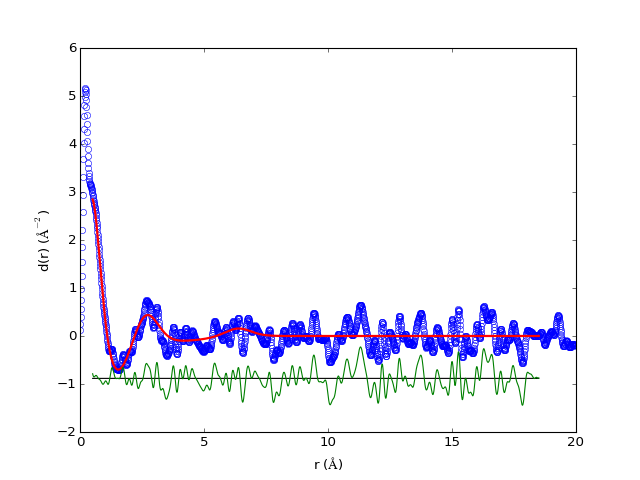

Refining...
Results for 050K:
[[Variables]]
    scalePara:   0.39732866 +/- 0        (0.00%) (init= 0.45)
    scaleNN1:    1.08191685 +/- 0        (0.00%) (init= 0.3422451)
    scaleNN2:    1.3101e-13 +/- 0        (0.00%) (init= 0.5962498)
    scaleNN3:    4.5683e-09 +/- 0        (0.00%) (init= 0.326567)
    scaleNN4:    0.46094064 +/- 0        (0.00%) (init= 0.2111403)
    scaleNN5:    0 (fixed)
    scaleNN6:    0 (fixed)
    dampNN1:     0.76035652 +/- 0        (0.00%) (init= 2.953609)
    dampNN2:     5.49814102 +/- 0        (0.00%) (init= 3.493722)
    dampNN3:     2.72388483 +/- 0        (0.00%) (init= 4.087126)
    dampNN4:     1.53087007 +/- 0        (0.00%) (init= 4.200312)
    dampNN5:     1000 (fixed)
    dampNN6:     1000 (fixed)
    width:       0.2 (fixed)
    damp:        100 (fixed)
    theta:       0 (fixed)
    phi:         0 (fixed)
[[Correlations]] (unreported correlations are <  0.100)
Final refined spin: [ 0.  0.  1.]

0.0534953829355


<IPython.core.display.Javascript object>


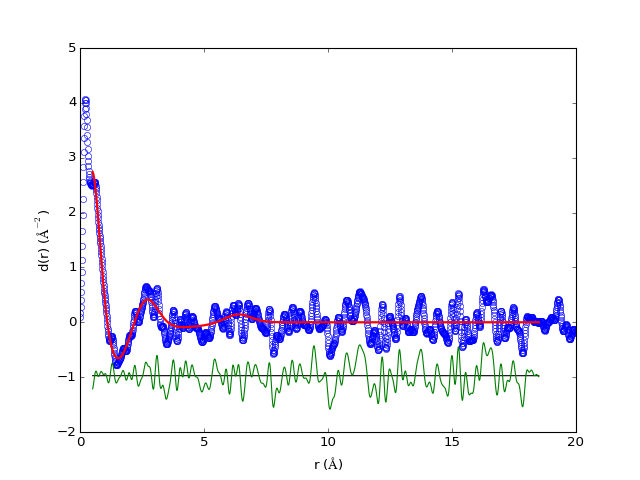

Refining...
Results for 100K:
[[Variables]]
    scalePara:   0.36682843 +/- 0.015206 (4.15%) (init= 0.45)
    scaleNN1:    0.96098091 +/- 0.161888 (16.85%) (init= 0.6324036)
    scaleNN2:    2.3831e-08 +/- 0.007567 (31755486.85%) (init= 0.3402805)
    scaleNN3:    5.3268e-08 +/- 0.650422 (1221041820.38%) (init= 0.6011951)
    scaleNN4:    0.45127949 +/- 0.635924 (140.92%) (init= 0.8866536)
    scaleNN5:    0 (fixed)
    scaleNN6:    0 (fixed)
    dampNN1:     0.77301097 +/- 0.046094 (5.96%) (init= 4.088264)
    dampNN2:     19.4566679 +/- 2.88e+07 (148207459.86%) (init= 3.83155)
    dampNN3:     1.70561961 +/- 5.51e+06 (323017305.94%) (init= 4.080404)
    dampNN4:     1.46626405 +/- 0.528950 (36.07%) (init= 4.68074)
    dampNN5:     1000 (fixed)
    dampNN6:     1000 (fixed)
    width:       0.2 (fixed)
    damp:        100 (fixed)
    theta:       0 (fixed)
    phi:         0 (fixed)
[[Correlations]] (unreported correlations are <  0.100)
    C(scaleNN3, dampNN3)         = -0.996 
   

<IPython.core.display.Javascript object>


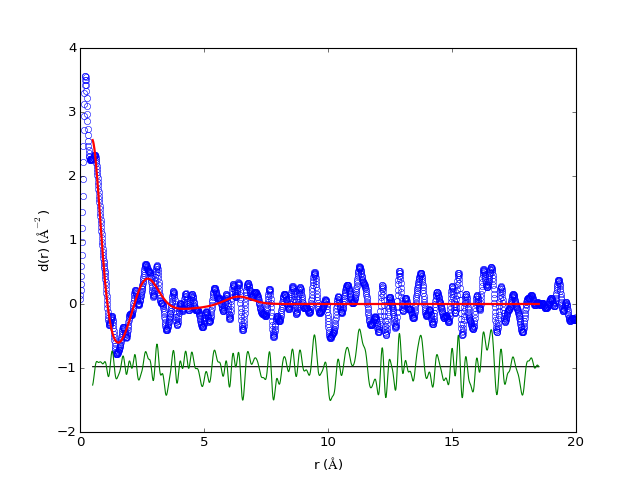

Refining...
Results for 130K:
[[Variables]]
    scalePara:   0.24668726 +/- 0.012306 (4.99%) (init= 0.45)
    scaleNN1:    0.44733910 +/- 0.104913 (23.45%) (init= 0.3428208)
    scaleNN2:    5.0944e-10 +/- 0.006745 (1324168918.48%) (init= 0.6420584)
    scaleNN3:    7.2406e-10 +/- 0.012193 (1684061782.62%) (init= 0.4663768)
    scaleNN4:    0.44472051 +/- 0.504475 (113.44%) (init= 0.754588)
    scaleNN5:    0 (fixed)
    scaleNN6:    0 (fixed)
    dampNN1:     0.91736103 +/- 0.084777 (9.24%) (init= 2.951836)
    dampNN2:     4.77392199 +/- 3.34e+07 (699250731.71%) (init= 3.377625)
    dampNN3:     4.99863302 +/- 6.43e+06 (128615975.67%) (init= 3.239103)
    dampNN4:     1.27546256 +/- 0.480760 (37.69%) (init= 1.366773)
    dampNN5:     1000 (fixed)
    dampNN6:     1000 (fixed)
    width:       0.2 (fixed)
    damp:        100 (fixed)
    theta:       0 (fixed)
    phi:         0 (fixed)
[[Correlations]] (unreported correlations are <  0.100)
    C(scaleNN3, dampNN3)         = -0.998 


<IPython.core.display.Javascript object>


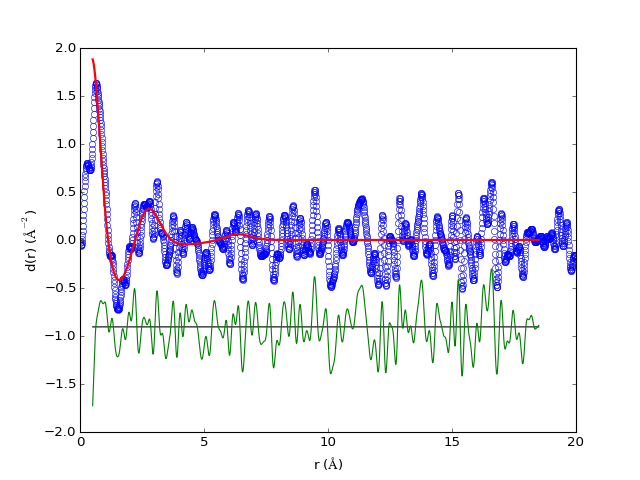

Refining...
Results for 150K:
[[Variables]]
    scalePara:   0.43633001 +/- 0.071756 (16.45%) (init= 0.45)
    scaleNN1:    0.83097948 +/- 0.368389 (44.33%) (init= 0.6509025)
    scaleNN2:    1.4465e-05 +/- 4.850320 (33530907.34%) (init= 0.7022914)
    scaleNN3:    0.32498611 +/- 0.671832 (206.73%) (init= 0.5240461)
    scaleNN4:    10.5899449 +/- 10.52799 (99.41%) (init= 0.3133107)
    scaleNN5:    0 (fixed)
    scaleNN6:    0 (fixed)
    dampNN1:     0.75812578 +/- 0.077526 (10.23%) (init= 4.041845)
    dampNN2:     0.57205686 +/- 1.21e+06 (210780426.27%) (init= 2.754767)
    dampNN3:     1.28388545 +/- 0.655996 (51.09%) (init= 4.888395)
    dampNN4:     0.37990477 +/- 0.016233 (4.27%) (init= 1.053693)
    dampNN5:     1000 (fixed)
    dampNN6:     1000 (fixed)
    width:       0.2 (fixed)
    damp:        100 (fixed)
    theta:       0 (fixed)
    phi:         0 (fixed)
[[Correlations]] (unreported correlations are <  0.100)
    C(scaleNN2, dampNN2)         = -0.983 
    C(scaleNN3,

<IPython.core.display.Javascript object>


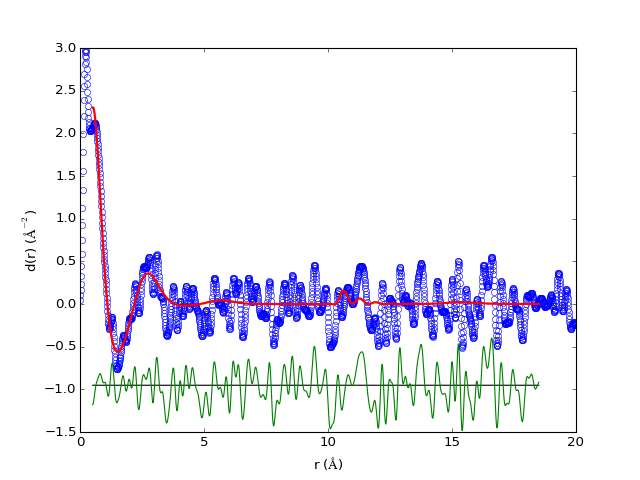

Refining...
Results for 200K:
[[Variables]]
    scalePara:   0.32649931 +/- 0.016105 (4.93%) (init= 0.45)
    scaleNN1:    0.83511261 +/- 0.170262 (20.39%) (init= 0.790739)
    scaleNN2:    4.2159e-10 +/- 0.000302 (71736897.89%) (init= 0.3358767)
    scaleNN3:    0.00059347 +/- 3.662001 (617052.02%) (init= 0.8487223)
    scaleNN4:    0.46508967 +/- 1.478330 (317.86%) (init= 0.850429)
    scaleNN5:    0 (fixed)
    scaleNN6:    0 (fixed)
    dampNN1:     0.78000620 +/- 0.046552 (5.97%) (init= 1.246087)
    dampNN2:     19.9999978 +/- 3.56e+05 (1778219.35%) (init= 2.826796)
    dampNN3:     0.97791215 +/- 1.03e+03 (105791.66%) (init= 3.817826)
    dampNN4:     1.28130975 +/- 0.844958 (65.94%) (init= 4.870036)
    dampNN5:     1000 (fixed)
    dampNN6:     1000 (fixed)
    width:       0.2 (fixed)
    damp:        100 (fixed)
    theta:       0 (fixed)
    phi:         0 (fixed)
[[Correlations]] (unreported correlations are <  0.100)
    C(scaleNN4, dampNN4)         = -0.994 
    C(scaleN

<IPython.core.display.Javascript object>


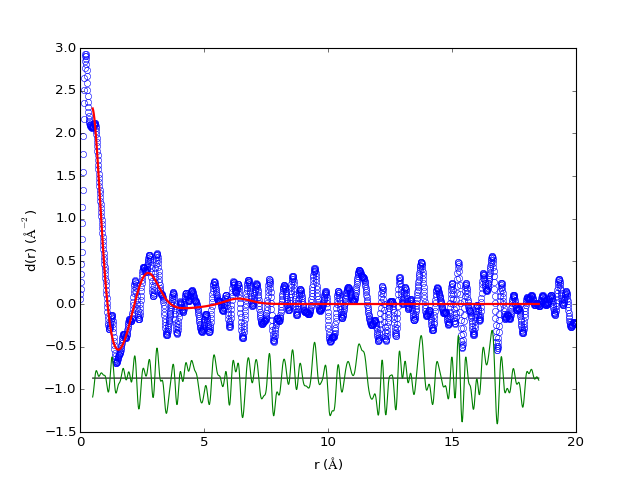

Refining...
Results for 250K:
[[Variables]]
    scalePara:   0.34360677 +/- 0.038765 (11.28%) (init= 0.45)
    scaleNN1:    0.89939871 +/- 0.156975 (17.45%) (init= 0.2611827)
    scaleNN2:    7.6105e-08 +/- 0.645411 (848053933.27%) (init= 0.7023403)
    scaleNN3:    1.21720527 +/- 6.408045 (526.46%) (init= 0.7976046)
    scaleNN4:    0.46410353 +/- 0.462064 (99.56%) (init= 0.8328791)
    scaleNN5:    0 (fixed)
    scaleNN6:    0 (fixed)
    dampNN1:     0.76329897 +/- 0.045013 (5.90%) (init= 4.958957)
    dampNN2:     0.94578951 +/- 1.08e+06 (113884293.12%) (init= 3.687041)
    dampNN3:     0.34991815 +/- 0.070765 (20.22%) (init= 1.002811)
    dampNN4:     1.27194344 +/- 0.283320 (22.27%) (init= 3.905342)
    dampNN5:     1000 (fixed)
    dampNN6:     1000 (fixed)
    width:       0.2 (fixed)
    damp:        100 (fixed)
    theta:       0 (fixed)
    phi:         0 (fixed)
[[Correlations]] (unreported correlations are <  0.100)
    C(scaleNN3, dampNN3)         =  0.998 
    C(scaleNN2

<IPython.core.display.Javascript object>


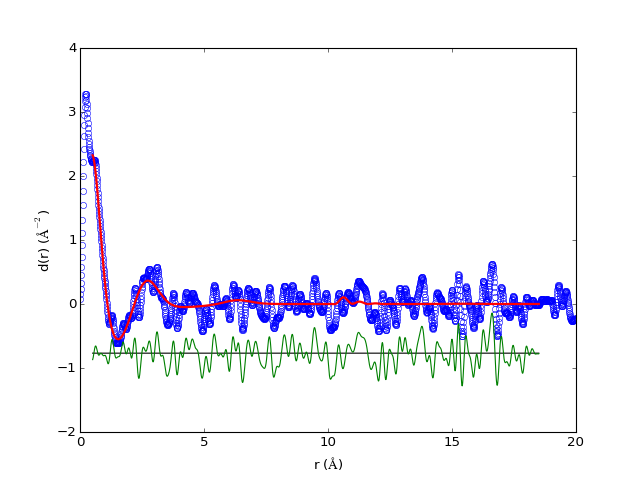

Refining...
Results for 300K:
[[Variables]]
    scalePara:   0.31296084 +/- 0        (0.00%) (init= 0.45)
    scaleNN1:    0.84266732 +/- 0        (0.00%) (init= 0.8774451)
    scaleNN2:    1.1102e-15 +/- 0        (0.00%) (init= 0.5437372)
    scaleNN3:    9.8474e-09 +/- 0        (0.00%) (init= 0.580172)
    scaleNN4:    0.44178152 +/- 0        (0.00%) (init= 0.5301786)
    scaleNN5:    0 (fixed)
    scaleNN6:    0 (fixed)
    dampNN1:     0.76349485 +/- 0        (0.00%) (init= 2.016998)
    dampNN2:     7.86134738 +/- 0        (0.00%) (init= 4.27161)
    dampNN3:     7.85040093 +/- 0        (0.00%) (init= 4.201504)
    dampNN4:     1.24666964 +/- 0        (0.00%) (init= 1.910425)
    dampNN5:     1000 (fixed)
    dampNN6:     1000 (fixed)
    width:       0.2 (fixed)
    damp:        100 (fixed)
    theta:       0 (fixed)
    phi:         0 (fixed)
[[Correlations]] (unreported correlations are <  0.100)
Final refined spin: [ 0.  0.  1.]

0.0336770406639


<IPython.core.display.Javascript object>


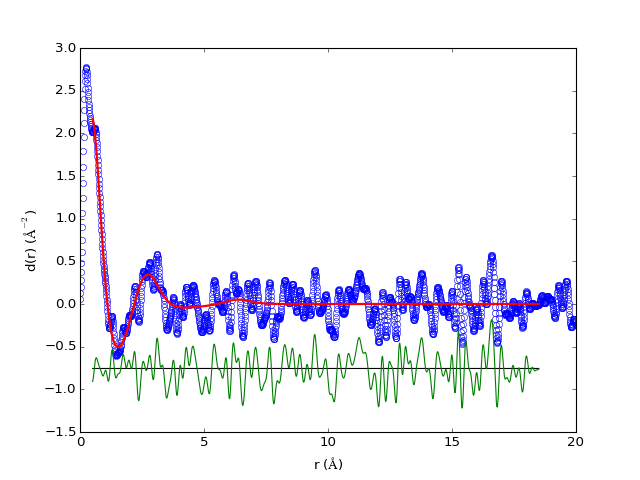

In [4]:
### Extract and save the experimental mPDF from the exported PDF fit file
inPrefix='x02y015/mPDF/exportedPDFfits/I4mmm_0-20_'
inSuffix='K.fgr'
outPrefix='x02y015/mPDF/exportedPDFfits/I4mmm_0-20_'
outSuffix='_scaleNorm.diff'
tempStrings=['002','050','100','130','150','200','250','300']

temps,scaleFactors=np.loadtxt('x02y015/mPDF/exportedPDFfits/qmax31lorch_I4mmm_Tscan_scale.dat',unpack=True)

### Set some important values for calculation and structure
rstep=0.01
rmin=0.5 # rmin and rmax set the data range for the fit
rmax=18.5
rcalcmin = 0 # The calculation is extended slightly beyond the fit range to avoid artifacts at boundaries.
rcalcmax=20

qmin,qmax=0.0,31.41

[dq,q1,q2] = [0.01,0.00,10.00]
q=np.arange(q1,q2,dq)   
ffMag=j0calc(q,[0.422,17.684,0.5948,6.005,0.0043,-0.609,-0.0219]) ### magnetic form factor for Ni2+

r1,r2,dr=-5.0,5.0,0.01
rsr, sr=costransform(q,ffMag,rmin=r1,rmax=r2,rstep=dr)
sr = np.sqrt(np.pi/2.0)*sr

rSr,Sr = cv(rsr,sr,rsr,sr)

para = -1.0*np.sqrt(2.0*np.pi)*np.gradient(Sr,rSr[1]-rSr[0]) ### paramagnetic term in d(r)

### Prepare the tetragonal structure for the calculations

### lattice parameters of magnetic unit cell, and some basis transformation stuff
e1=np.array([1,0,0])
e1n=e1/np.linalg.norm(e1)
e2=np.array([0,1,0])
e2n=e2/np.linalg.norm(e2)
e3=np.array([0,0,1])
e3n=e3/np.linalg.norm(e3)

temps,aVals=np.loadtxt('x02y015/mPDF/exportedPDFfits/qmax31lorch_I4mmm_Tscan_a-lat.dat',unpack=True)
temps,cVals=np.loadtxt('x02y015/mPDF/exportedPDFfits/qmax31lorch_I4mmm_Tscan_c-lat.dat',unpack=True)

Basis=np.array([e1,e2,e3])
IBasis=np.linalg.inv(Basis)
BasisN=np.array([e1n,e2n,e3n])

### positions of atoms in magnetic unit cell
basis=np.array([[0.5,0,0.75],[0,0.5,0.75],[0.5,0,0.25],[0,0.5,0.25]])

scaleParas=np.zeros_like(temps)
scaleCorrs=np.zeros_like(temps)
thetas=np.zeros_like(temps)
phis=np.zeros_like(temps)
damps=np.zeros_like(temps)
widths=np.zeros_like(temps)
chisqs=np.zeros_like(temps)
### loop through the temperatures to do the refinements
for i in range(len(temps)):
    a=aVals[i]
    b=aVals[i]
    c=cVals[i]    
    latpars=np.array([[a],[b],[c]])
    full=BasisN*latpars
    cell=np.dot(IBasis,full)
    atomcell=np.dot(basis,cell)
    
    ### spin orientations in same order as atomic positions.
    svec=np.array([0,0,1])
    svec=svec/np.linalg.norm(svec)
    svecmag=np.sqrt((svec*svec).sum())
    theta0=np.arccos(svec[2]/svecmag)
    phi0=np.arctan2(svec[1],svec[0])
    S=2.5
    spincell=S*np.array([svec,svec,svec,svec])


    ### how big to make the box
    radius=1.5*rcalcmax
    dim1=np.round(radius/np.linalg.norm(cell[0]))
    dim2=np.round(radius/np.linalg.norm(cell[1]))
    dim3=np.round(radius/np.linalg.norm(cell[2]))

    ### generate the coordinates of each unit cell 
    latos=np.dot(np.mgrid[-dim1:dim1+1,-dim2:dim2+1,-dim3:dim3+1].transpose().ravel().reshape((2*dim1+1)*(2*dim2+1)*(2*dim3+1),3),cell)

    ### select points within a desired radius from origin
    latos=latos[np.where(np.apply_along_axis(np.linalg.norm,1,latos)<=(rcalcmax+10.0))]

    ## rearrange latos array so that [0,0,0] is the first one (for convenience)
    latos[np.where(np.all(latos==[0,0,0],axis=1))]=latos[0]
    latos[0]=np.array([0,0,0])

    ### create list of all atomic positions and spin directions
    atoms=np.empty([len(latos)*len(atomcell),3])
    spins=np.empty([len(latos)*len(spincell),3])
    index=0
    for k in range(len(latos)):
        for j in range(len(atomcell)):
            atoms[index]=latos[k]+atomcell[j]
            spins[index] = spincell[j]
            index+=1

    datoms = atoms-atoms[0]
    datomsmag = np.sqrt(np.sum((datoms)**2,axis=1).reshape(datoms.shape[0],1)).ravel()
    datomsmag = np.around(datomsmag,decimals=5)
    shellvals = np.unique(datomsmag)
    
    ### Extract neighbor shells
    atomsNN1,spinsNN1=neighborFinder(1,atoms,spins)
    atomsNN2,spinsNN2=neighborFinder(2,atoms,spins)
    atomsNN3,spinsNN3=neighborFinder(3,atoms,spins)
    atomsNN4,spinsNN4=neighborFinder(4,atoms,spins)
    atomsNN5,spinsNN5=neighborFinder(5,atoms,spins)
    atomsNN6,spinsNN6=neighborFinder(6,atoms,spins)
    
    uclist=np.array([0]) # indices of atoms which will be used as centers in the mPDF calculation
    x=np.array([0]) # empty array to be used as placeholder in the calculations

    dataFileName=outPrefix+tempStrings[i]+outSuffix
    expr,expDr = np.loadtxt(dataFileName,unpack=True) # grab the experimental data.

    print 'Refining...'

    fit_params = Parameters()
    fit_params.add('scalePara', value=0.45,min=0,max=20.0)
    fit_params.add('scaleNN1', value=np.random.uniform(0,1.0),min=0.0,max=20)
    fit_params.add('scaleNN2', value=np.random.uniform(0,1.0),min=0.0,max=20)
    fit_params.add('scaleNN3', value=np.random.uniform(0,1.0),min=0.0,max=3)
    fit_params.add('scaleNN4', value=np.random.uniform(0,1.0),min=0.0,max=20)
    fit_params.add('scaleNN5', value=0,vary=False)#np.random.uniform(0,1.0),min=0.0,max=20)
    fit_params.add('scaleNN6', value=0,vary=False)#np.random.uniform(0,1.0),min=0.0,max=20)
    fit_params.add('dampNN1',value=np.random.uniform(1,5),min=0.0,max=20)
    fit_params.add('dampNN2',value=np.random.uniform(1,5),min=0.0,max=20)
    fit_params.add('dampNN3',value=np.random.uniform(1,5),min=0.0,max=20)
    fit_params.add('dampNN4',value=np.random.uniform(1,5),min=0.0,max=20)
    fit_params.add('dampNN5',value=1000,vary=False)#np.random.uniform(1,5),min=0.0,max=20)
    fit_params.add('dampNN6',value=1000,vary=False)#np.random.uniform(1,5),min=0.0,max=20)
    fit_params.add('width', value=0.2,vary=False)
    fit_params.add('damp', value=100,vary=False)#min=0.1,max=100)#vary=False)
    fit_params.add('theta',value=theta0,vary=False)#np.arccos(np.random.uniform(-1,1)),min=0.000001,max=np.pi)
    fit_params.add('phi',value=theta0,vary=False)#np.random.uniform(-1.0*np.pi, np.pi),min=-1.0*np.pi,max=np.pi)

    data=expDr[np.logical_and(expr>rmin+0.5*rstep,expr<=rmax+0.5*rstep)]
    out = minimize(shellResidual, fit_params, args=(x,), kws={'data':data})

    fit = shellResidual(fit_params, x)
    print 'Results for '+tempStrings[i]+'K:'
    print fit_report(fit_params)

    refinedVals=fit_params.valuesdict()
    scaleNN1=refinedVals['scaleNN1']
    scaleNN2=refinedVals['scaleNN2']
    scaleNN3=refinedVals['scaleNN3']
    scaleNN4=refinedVals['scaleNN4']
    scaleNN5=refinedVals['scaleNN5']
    scaleNN6=refinedVals['scaleNN6']
    scalePara=refinedVals['scalePara']
    width=refinedVals['width']
    damp=refinedVals['damp']
    dampNN1=refinedVals['dampNN1']
    dampNN2=refinedVals['dampNN2']
    dampNN3=refinedVals['dampNN3']
    dampNN4=refinedVals['dampNN4']
    dampNN5=refinedVals['dampNN5']
    dampNN6=refinedVals['dampNN6']
    theta=refinedVals['theta']
    phi=refinedVals['phi']
    
#    scaleCorrs[i]=scaleCorr
#    scaleParas[i]=scalePara
#    damps[i]=damp
#    widths[i]=width
#    thetas[i]=theta
#    phis[i]=phi
    
    finalSpin=np.array([np.sin(theta)*np.cos(phi),np.sin(theta)*np.sin(phi),np.cos(theta)])
    print 'Final refined spin: '+str(finalSpin)+'\n'

    rcomp = expr[np.logical_and(expr>rmin+0.5*rstep,expr<=rmax+0.5*rstep)]
    diff = data-fit
    chisq=np.sum((diff)**2/len(diff))
    print chisq
    chisqs[i]=chisq
    
    spins[:]=S*finalSpin
    [r,fr]=shellcalc(x,rmin,rmax,scaleNN1,scaleNN2,scaleNN3,scaleNN4,scaleNN5,scaleNN6,scalePara,width,theta,phi,damp,dampNN1,dampNN2,dampNN3,dampNN4,dampNN5,dampNN6)[1:]

    rfull=expr[np.logical_and(expr>rcalcmin+0.5*rstep,expr<=rcalcmax+0.5*rstep)]
    datafull=expDr[np.logical_and(expr>rcalcmin+0.5*rstep,expr<=rcalcmax+0.5*rstep)]
    compexpDr=expDr[np.logical_and(expr>rmin+0.5*rstep,expr<=rmax+0.5*rstep)]

    offset = 1.25*np.abs(np.min(data))

    fig=plt.figure()
    ax=fig.add_subplot(111)
    ax.plot(rfull,datafull,marker='o',mfc='none',mec='b',linestyle='none')
    ax.plot(rcomp,fit,'r-',lw=2)
    ax.plot(rcomp,np.zeros_like(rcomp)-offset,'k-',rcomp,diff-offset,'g-')
    #ax.plot(r,fr,'b-')
    ax.set_xlim(xmin=rcalcmin,xmax=rcalcmax)
    ax.set_xlabel('r ($\AA$)')
    ax.set_ylabel('d(r) ($\AA^{-2}$)')

    plt.show()

    ###### provide options to save data
    fitstring=' Experimental data: '+dataFileName+\
                '\n Chi-squared: '+str(chisq)+\
                '\n NN1 scale, damp: '+str(scaleNN1)+'\t'+str(dampNN1)+\
                '\n NN2 scale, damp: '+str(scaleNN2)+'\t'+str(dampNN2)+\
                '\n NN3 scale, damp: '+str(scaleNN3)+'\t'+str(dampNN3)+\
                '\n NN4 scale, damp: '+str(scaleNN4)+'\t'+str(dampNN4)+\
                '\n NN5 scale, damp: '+str(scaleNN5)+'\t'+str(dampNN5)+\
                '\n NN6 scale, damp: '+str(scaleNN6)+'\t'+str(dampNN6)+\
                '\n Paramagnetic scale: '+str(scalePara)+\
                '\n Broadening factor: '+str(width)+\
                '\n Theta: '+str(theta)+\
                '\n Phi: '+str(phi)+\
                '\n Damp: '+str(damp)+\
                '\n '+\
                    '\n Column format: r, Obs., Calc., Diff.'
    savefile='x02y015/mPDF/mPDFfit_I4mmm_0-20_ferroFree_shell_'+tempStrings[i]+'K_1.txt'
    np.savetxt(savefile,np.column_stack((rcomp,data,fit,diff)),header=fitstring)


In [ ]:
plt.close('all')

So, the shell-by-shell SRO model does a slightly better job than the LRO model (mostly by getting the 4th NN), but only if I allow independent damping parameters for each shell, i.e. just having independent scale factors alone is not enough. This may be physically justifiable, since the contribution from every coordination shell contains a low-r part (although it disappears as 1/r_{ij}^3).

Do a double-check with the lower qmax data set.

Refining...
Results for 002K:
[[Variables]]
    scalePara:   0.44417834 +/- 0        (0.00%) (init= 0.45)
    scaleNN1:    1.24544815 +/- 0        (0.00%) (init= 0.4956367)
    scaleNN2:    1.1102e-15 +/- 0        (0.00%) (init= 0.9334716)
    scaleNN3:    2.6830e-10 +/- 0        (0.00%) (init= 0.5410816)
    scaleNN4:    0.54065486 +/- 0        (0.00%) (init= 0.5957717)
    scaleNN5:    0 (fixed)
    scaleNN6:    0 (fixed)
    dampNN1:     0.75703916 +/- 0        (0.00%) (init= 4.349645)
    dampNN2:     2.31390980 +/- 0        (0.00%) (init= 2.3188)
    dampNN3:     6.06986519 +/- 0        (0.00%) (init= 3.565876)
    dampNN4:     1.52315784 +/- 0        (0.00%) (init= 1.271833)
    dampNN5:     1000 (fixed)
    dampNN6:     1000 (fixed)
    width:       0.2 (fixed)
    damp:        100 (fixed)
    theta:       0 (fixed)
    phi:         0 (fixed)
[[Correlations]] (unreported correlations are <  0.100)
Final refined spin: [ 0.  0.  1.]

0.0710716408188


C:\Users\benfr\Anaconda\lib\site-packages\ipykernel\__main__.py:88: DeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


<IPython.core.display.Javascript object>


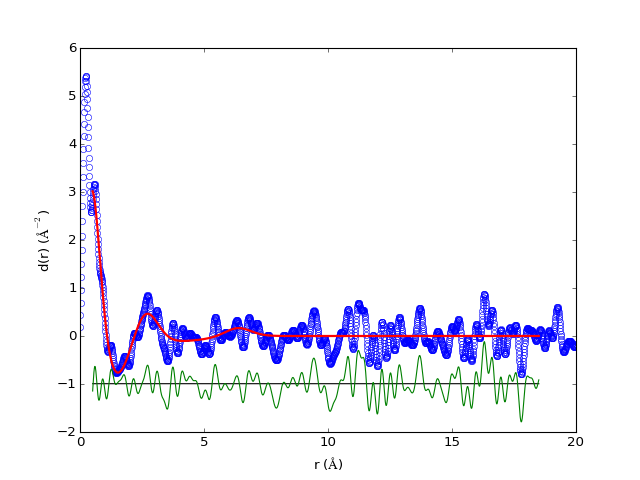

Refining...
Results for 050K:
[[Variables]]
    scalePara:   0.45195866 +/- 0.048079 (10.64%) (init= 0.45)
    scaleNN1:    1.28419240 +/- 0.227465 (17.71%) (init= 0.7950765)
    scaleNN2:    4.1396e-09 +/- 0.008004 (193370788.70%) (init= 0.7657544)
    scaleNN3:    2.99612888 +/- 7.575432 (252.84%) (init= 0.05435111)
    scaleNN4:    0.43922302 +/- 0.142536 (32.45%) (init= 0.4180927)
    scaleNN5:    0 (fixed)
    scaleNN6:    0 (fixed)
    dampNN1:     0.73428367 +/- 0.043930 (5.98%) (init= 2.755264)
    dampNN2:     5.20725998 +/- 1.03e+07 (198486403.06%) (init= 1.373922)
    dampNN3:     0.34612628 +/- 0.033506 (9.68%) (init= 3.891613)
    dampNN4:     1.57347264 +/- 0.164102 (10.43%) (init= 3.361476)
    dampNN5:     1000 (fixed)
    dampNN6:     1000 (fixed)
    width:       0.2 (fixed)
    damp:        100 (fixed)
    theta:       0 (fixed)
    phi:         0 (fixed)
[[Correlations]] (unreported correlations are <  0.100)
    C(scaleNN3, dampNN3)         =  0.998 
    C(scaleNN1

<IPython.core.display.Javascript object>


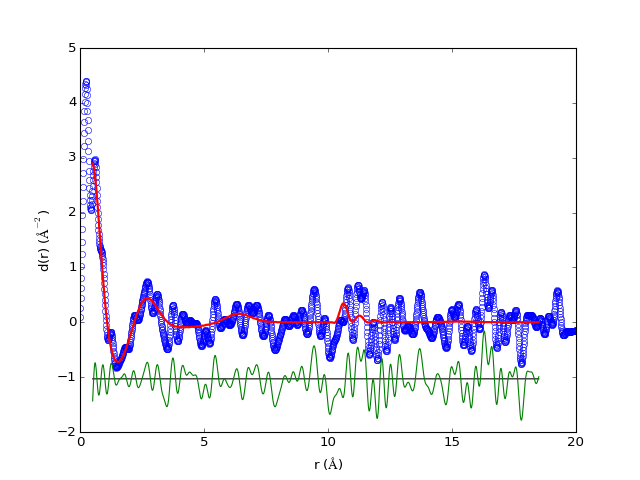

Refining...
Results for 100K:
[[Variables]]
    scalePara:   0.40241147 +/- 0.067059 (16.66%) (init= 0.45)
    scaleNN1:    1.15805619 +/- 0.364304 (31.46%) (init= 0.9931041)
    scaleNN2:    3.9519e-09 +/- 0.017561 (444378402.20%) (init= 0.189972)
    scaleNN3:    8.6250e-09 +/- 9.754731 (113098800885.43%) (init= 0.08209477)
    scaleNN4:    0.45436109 +/- 0.525190 (115.59%) (init= 0.7899396)
    scaleNN5:    0 (fixed)
    scaleNN6:    0 (fixed)
    dampNN1:     0.74466536 +/- 0.053576 (7.19%) (init= 1.076184)
    dampNN2:     4.33257083 +/- 1.98e+07 (457532789.20%) (init= 1.187859)
    dampNN3:     0.46544327 +/- 7.45e+06 (1599917069.86%) (init= 1.861014)
    dampNN4:     1.48638526 +/- 0.417154 (28.07%) (init= 4.635422)
    dampNN5:     1000 (fixed)
    dampNN6:     1000 (fixed)
    width:       0.2 (fixed)
    damp:        100 (fixed)
    theta:       0 (fixed)
    phi:         0 (fixed)
[[Correlations]] (unreported correlations are <  0.100)
    C(scaleNN4, dampNN4)         = -0.9

<IPython.core.display.Javascript object>


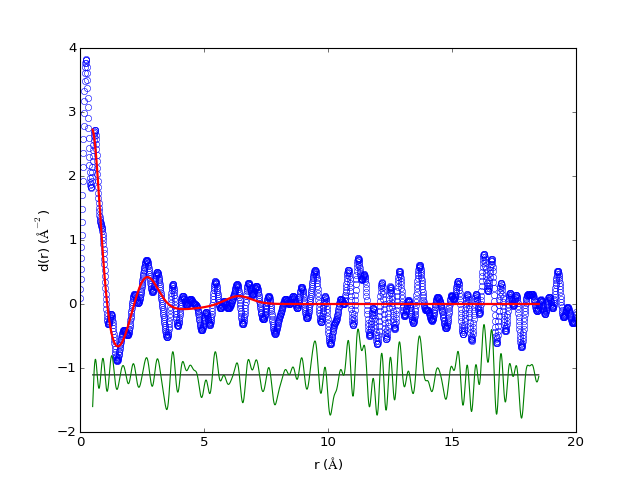

Refining...
Results for 130K:
[[Variables]]
    scalePara:   0.28472156 +/- 0.094866 (33.32%) (init= 0.45)
    scaleNN1:    0.53209556 +/- 0.253677 (47.68%) (init= 0.7389319)
    scaleNN2:    4.9793e-08 +/- 0.356216 (715395519.57%) (init= 0.9808698)
    scaleNN3:    2.99999878 +/- 9.382125 (312.74%) (init= 0.9827245)
    scaleNN4:    0.40718502 +/- 0.381004 (93.57%) (init= 0.1083436)
    scaleNN5:    0 (fixed)
    scaleNN6:    0 (fixed)
    dampNN1:     0.87696647 +/- 0.123593 (14.09%) (init= 1.844032)
    dampNN2:     0.47897669 +/- 2.71e+04 (5655134.60%) (init= 1.694004)
    dampNN3:     0.35523496 +/- 0.069173 (19.47%) (init= 4.615225)
    dampNN4:     1.31377655 +/- 0.328779 (25.03%) (init= 4.097647)
    dampNN5:     1000 (fixed)
    dampNN6:     1000 (fixed)
    width:       0.2 (fixed)
    damp:        100 (fixed)
    theta:       0 (fixed)
    phi:         0 (fixed)
[[Correlations]] (unreported correlations are <  0.100)
    C(scaleNN3, dampNN3)         =  0.999 
    C(scaleNN2,

<IPython.core.display.Javascript object>


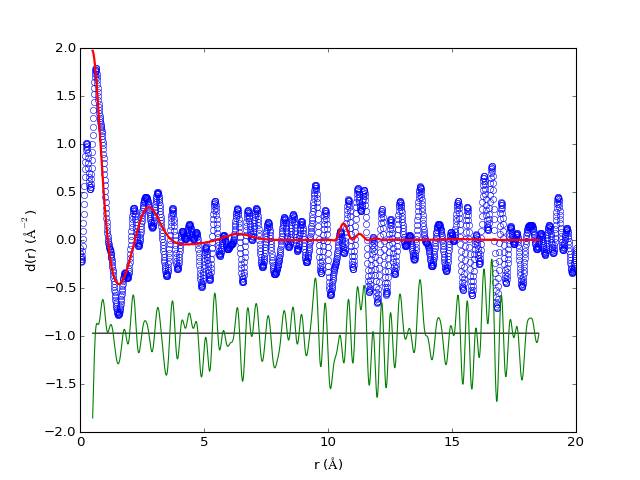

Refining...
Results for 150K:
[[Variables]]
    scalePara:   0.41969612 +/- 0.059991 (14.29%) (init= 0.45)
    scaleNN1:    1.02333789 +/- 0.226229 (22.11%) (init= 0.96949)
    scaleNN2:    2.84444829 +/- 3.553142 (124.91%) (init= 0.1480164)
    scaleNN3:    5.0695e-11 +/- 0.007797 (15381537945.49%) (init= 0.7297068)
    scaleNN4:    0.33198937 +/- 0.218135 (65.71%) (init= 0.1916997)
    scaleNN5:    0 (fixed)
    scaleNN6:    0 (fixed)
    dampNN1:     0.74564401 +/- 0.051978 (6.97%) (init= 4.153318)
    dampNN2:     0.36637689 +/- 0.018415 (5.03%) (init= 1.098856)
    dampNN3:     5.68020132 +/- 8.05e+07 (1417279114.81%) (init= 4.563111)
    dampNN4:     1.44980873 +/- 0.292725 (20.19%) (init= 3.140973)
    dampNN5:     1000 (fixed)
    dampNN6:     1000 (fixed)
    width:       0.2 (fixed)
    damp:        100 (fixed)
    theta:       0 (fixed)
    phi:         0 (fixed)
[[Correlations]] (unreported correlations are <  0.100)
    C(scaleNN2, dampNN2)         =  0.984 
    C(scalePar

<IPython.core.display.Javascript object>


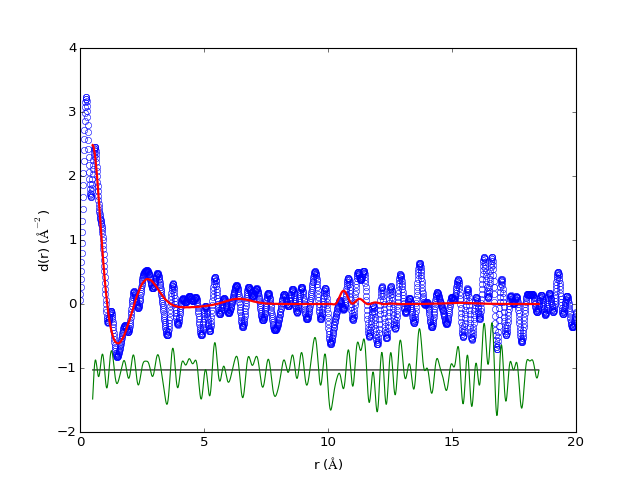

Refining...
Results for 200K:
[[Variables]]
    scalePara:   0.37150703 +/- 0.055498 (14.94%) (init= 0.45)
    scaleNN1:    0.99903391 +/- 0.203644 (20.38%) (init= 0.09793213)
    scaleNN2:    1.4558e-10 +/- 0.002672 (1835789990.57%) (init= 0.008869675)
    scaleNN3:    2.69953238 +/- 9.406338 (348.44%) (init= 0.7463536)
    scaleNN4:    0.41939217 +/- 0.216617 (51.65%) (init= 0.5010756)
    scaleNN5:    0 (fixed)
    scaleNN6:    0 (fixed)
    dampNN1:     0.74800412 +/- 0.049615 (6.63%) (init= 1.904269)
    dampNN2:     13.0333620 +/- 8.46e+07 (649363949.03%) (init= 2.99147)
    dampNN3:     0.35610545 +/- 0.047891 (13.45%) (init= 1.194527)
    dampNN4:     1.32304290 +/- 0.208081 (15.73%) (init= 3.491676)
    dampNN5:     1000 (fixed)
    dampNN6:     1000 (fixed)
    width:       0.2 (fixed)
    damp:        100 (fixed)
    theta:       0 (fixed)
    phi:         0 (fixed)
[[Correlations]] (unreported correlations are <  0.100)
    C(scaleNN3, dampNN3)         =  0.996 
    C(scale

<IPython.core.display.Javascript object>


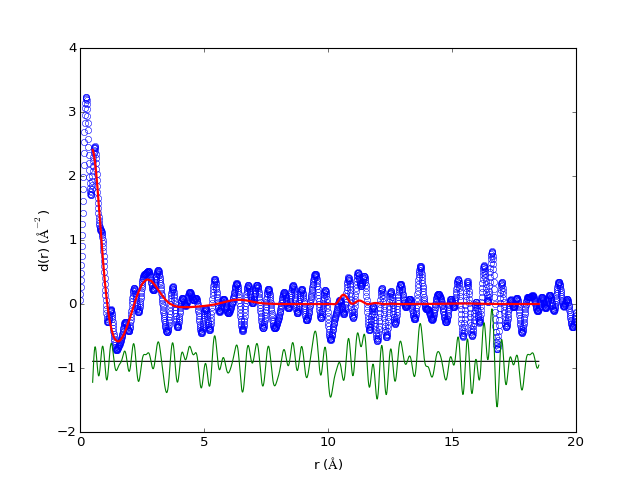

Refining...
Results for 250K:
[[Variables]]
    scalePara:   0.36296042 +/- 0        (0.00%) (init= 0.45)
    scaleNN1:    1.05766931 +/- 0        (0.00%) (init= 0.6338025)
    scaleNN2:    6.4127e-10 +/- 0        (0.00%) (init= 0.04238989)
    scaleNN3:    1.6653e-16 +/- 0        (0.00%) (init= 0.158775)
    scaleNN4:    0.47739231 +/- 0        (0.00%) (init= 0.261841)
    scaleNN5:    0 (fixed)
    scaleNN6:    0 (fixed)
    dampNN1:     0.73782044 +/- 0        (0.00%) (init= 2.794958)
    dampNN2:     12.7899314 +/- 0        (0.00%) (init= 3.595878)
    dampNN3:     3.47860180 +/- 0        (0.00%) (init= 3.553172)
    dampNN4:     1.27360462 +/- 0        (0.00%) (init= 3.895188)
    dampNN5:     1000 (fixed)
    dampNN6:     1000 (fixed)
    width:       0.2 (fixed)
    damp:        100 (fixed)
    theta:       0 (fixed)
    phi:         0 (fixed)
[[Correlations]] (unreported correlations are <  0.100)
Final refined spin: [ 0.  0.  1.]

0.056462810613


<IPython.core.display.Javascript object>


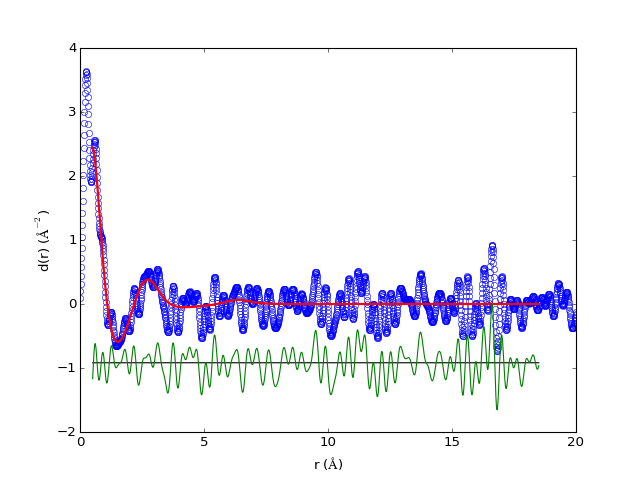

Refining...
Results for 300K:
[[Variables]]
    scalePara:   0.34298580 +/- 0.059634 (17.39%) (init= 0.45)
    scaleNN1:    0.98736452 +/- 0.270635 (27.41%) (init= 0.1342806)
    scaleNN2:    0.35058731 +/- 70.50886 (20111.64%) (init= 0.9490517)
    scaleNN3:    0.47694111 +/- 203.8295 (42736.84%) (init= 0.3087101)
    scaleNN4:    0.40086623 +/- 0.322478 (80.45%) (init= 0.8527533)
    scaleNN5:    0 (fixed)
    scaleNN6:    0 (fixed)
    dampNN1:     0.73280853 +/- 0.065001 (8.87%) (init= 4.288483)
    dampNN2:     0.35174974 +/- 4.150808 (1180.05%) (init= 3.334243)
    dampNN3:     0.35223738 +/- 9.224388 (2618.80%) (init= 2.097669)
    dampNN4:     1.27366589 +/- 0.246816 (19.38%) (init= 4.106073)
    dampNN5:     1000 (fixed)
    dampNN6:     1000 (fixed)
    width:       0.2 (fixed)
    damp:        100 (fixed)
    theta:       0 (fixed)
    phi:         0 (fixed)
[[Correlations]] (unreported correlations are <  0.100)
    C(dampNN2, dampNN3)          = -0.999 
    C(scaleNN2, sca

<IPython.core.display.Javascript object>


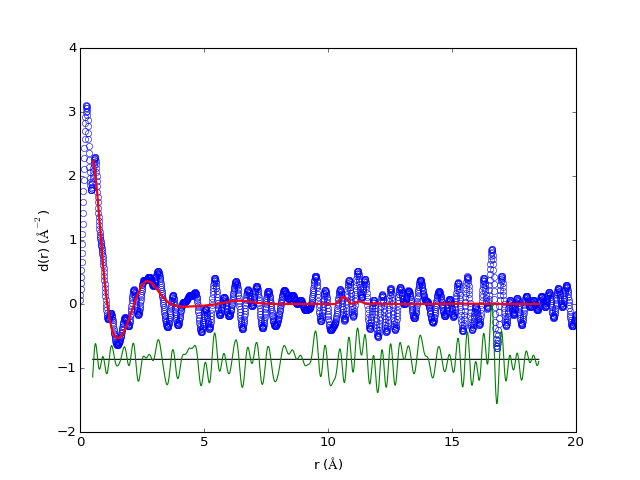

In [5]:
### Extract and save the experimental mPDF from the exported PDF fit file
inPrefix='x02y015/mPDF/exportedPDFfits/I4mmm_0-20_qmax20_'
inSuffix='K.fgr'
outPrefix='x02y015/mPDF/exportedPDFfits/I4mmm_0-20_qmax20_'
outSuffix='_scaleNorm.diff'
tempStrings=['002','050','100','130','150','200','250','300']

temps,scaleFactors=np.loadtxt('x02y015/mPDF/exportedPDFfits/qmax20full_I4mmm_Tscan_scale.dat',unpack=True)

for i in range(len(tempStrings)):
    PDFdiffGrabber(inPrefix+tempStrings[i]+inSuffix,outPrefix+tempStrings[i]+outSuffix,scale=scaleFactors[i])

### Set some important values for calculation and structure
rstep=0.01
rmin=0.5 # rmin and rmax set the data range for the fit
rmax=18.5
rcalcmin = 0 # The calculation is extended slightly beyond the fit range to avoid artifacts at boundaries.
rcalcmax=20

qmin,qmax=0.0,31.41

[dq,q1,q2] = [0.01,0.00,10.00]
q=np.arange(q1,q2,dq)   
ffMag=j0calc(q,[0.422,17.684,0.5948,6.005,0.0043,-0.609,-0.0219]) ### magnetic form factor for Ni2+

r1,r2,dr=-5.0,5.0,0.01
rsr, sr=costransform(q,ffMag,rmin=r1,rmax=r2,rstep=dr)
sr = np.sqrt(np.pi/2.0)*sr

rSr,Sr = cv(rsr,sr,rsr,sr)

para = -1.0*np.sqrt(2.0*np.pi)*np.gradient(Sr,rSr[1]-rSr[0]) ### paramagnetic term in d(r)

### Prepare the tetragonal structure for the calculations

### lattice parameters of magnetic unit cell, and some basis transformation stuff
e1=np.array([1,0,0])
e1n=e1/np.linalg.norm(e1)
e2=np.array([0,1,0])
e2n=e2/np.linalg.norm(e2)
e3=np.array([0,0,1])
e3n=e3/np.linalg.norm(e3)

temps,aVals=np.loadtxt('x02y015/mPDF/exportedPDFfits/qmax31lorch_I4mmm_Tscan_a-lat.dat',unpack=True)
temps,cVals=np.loadtxt('x02y015/mPDF/exportedPDFfits/qmax31lorch_I4mmm_Tscan_c-lat.dat',unpack=True)

Basis=np.array([e1,e2,e3])
IBasis=np.linalg.inv(Basis)
BasisN=np.array([e1n,e2n,e3n])

### positions of atoms in magnetic unit cell
basis=np.array([[0.5,0,0.75],[0,0.5,0.75],[0.5,0,0.25],[0,0.5,0.25]])

scaleParas=np.zeros_like(temps)
scaleCorrs=np.zeros_like(temps)
thetas=np.zeros_like(temps)
phis=np.zeros_like(temps)
damps=np.zeros_like(temps)
widths=np.zeros_like(temps)
chisqs=np.zeros_like(temps)
### loop through the temperatures to do the refinements
for i in range(len(temps)):
    a=aVals[i]
    b=aVals[i]
    c=cVals[i]    
    latpars=np.array([[a],[b],[c]])
    full=BasisN*latpars
    cell=np.dot(IBasis,full)
    atomcell=np.dot(basis,cell)
    
    ### spin orientations in same order as atomic positions.
    svec=np.array([0,0,1])
    svec=svec/np.linalg.norm(svec)
    svecmag=np.sqrt((svec*svec).sum())
    theta0=np.arccos(svec[2]/svecmag)
    phi0=np.arctan2(svec[1],svec[0])
    S=2.5
    spincell=S*np.array([svec,svec,svec,svec])


    ### how big to make the box
    radius=1.5*rcalcmax
    dim1=np.round(radius/np.linalg.norm(cell[0]))
    dim2=np.round(radius/np.linalg.norm(cell[1]))
    dim3=np.round(radius/np.linalg.norm(cell[2]))

    ### generate the coordinates of each unit cell 
    latos=np.dot(np.mgrid[-dim1:dim1+1,-dim2:dim2+1,-dim3:dim3+1].transpose().ravel().reshape((2*dim1+1)*(2*dim2+1)*(2*dim3+1),3),cell)

    ### select points within a desired radius from origin
    latos=latos[np.where(np.apply_along_axis(np.linalg.norm,1,latos)<=(rcalcmax+10.0))]

    ## rearrange latos array so that [0,0,0] is the first one (for convenience)
    latos[np.where(np.all(latos==[0,0,0],axis=1))]=latos[0]
    latos[0]=np.array([0,0,0])

    ### create list of all atomic positions and spin directions
    atoms=np.empty([len(latos)*len(atomcell),3])
    spins=np.empty([len(latos)*len(spincell),3])
    index=0
    for k in range(len(latos)):
        for j in range(len(atomcell)):
            atoms[index]=latos[k]+atomcell[j]
            spins[index] = spincell[j]
            index+=1

    datoms = atoms-atoms[0]
    datomsmag = np.sqrt(np.sum((datoms)**2,axis=1).reshape(datoms.shape[0],1)).ravel()
    datomsmag = np.around(datomsmag,decimals=5)
    shellvals = np.unique(datomsmag)
    
    ### Extract neighbor shells
    atomsNN1,spinsNN1=neighborFinder(1,atoms,spins)
    atomsNN2,spinsNN2=neighborFinder(2,atoms,spins)
    atomsNN3,spinsNN3=neighborFinder(3,atoms,spins)
    atomsNN4,spinsNN4=neighborFinder(4,atoms,spins)
    atomsNN5,spinsNN5=neighborFinder(5,atoms,spins)
    atomsNN6,spinsNN6=neighborFinder(6,atoms,spins)
    
    uclist=np.array([0]) # indices of atoms which will be used as centers in the mPDF calculation
    x=np.array([0]) # empty array to be used as placeholder in the calculations

    dataFileName=outPrefix+tempStrings[i]+outSuffix
    expr,expDr = np.loadtxt(dataFileName,unpack=True) # grab the experimental data.

    print 'Refining...'

    fit_params = Parameters()
    fit_params.add('scalePara', value=0.45,min=0,max=20.0)
    fit_params.add('scaleNN1', value=np.random.uniform(0,1.0),min=0.0,max=20)
    fit_params.add('scaleNN2', value=np.random.uniform(0,1.0),min=0.0,max=20)
    fit_params.add('scaleNN3', value=np.random.uniform(0,1.0),min=0.0,max=3)
    fit_params.add('scaleNN4', value=np.random.uniform(0,1.0),min=0.0,max=20)
    fit_params.add('scaleNN5', value=0,vary=False)#np.random.uniform(0,1.0),min=0.0,max=20)
    fit_params.add('scaleNN6', value=0,vary=False)#np.random.uniform(0,1.0),min=0.0,max=20)
    fit_params.add('dampNN1',value=np.random.uniform(1,5),min=0.0,max=20)
    fit_params.add('dampNN2',value=np.random.uniform(1,5),min=0.0,max=20)
    fit_params.add('dampNN3',value=np.random.uniform(1,5),min=0.0,max=20)
    fit_params.add('dampNN4',value=np.random.uniform(1,5),min=0.0,max=20)
    fit_params.add('dampNN5',value=1000,vary=False)#np.random.uniform(1,5),min=0.0,max=20)
    fit_params.add('dampNN6',value=1000,vary=False)#np.random.uniform(1,5),min=0.0,max=20)
    fit_params.add('width', value=0.2,vary=False)
    fit_params.add('damp', value=100,vary=False)#min=0.1,max=100)#vary=False)
    fit_params.add('theta',value=theta0,vary=False)#np.arccos(np.random.uniform(-1,1)),min=0.000001,max=np.pi)
    fit_params.add('phi',value=theta0,vary=False)#np.random.uniform(-1.0*np.pi, np.pi),min=-1.0*np.pi,max=np.pi)

    data=expDr[np.logical_and(expr>rmin+0.5*rstep,expr<=rmax+0.5*rstep)]
    out = minimize(shellResidual, fit_params, args=(x,), kws={'data':data})

    fit = shellResidual(fit_params, x)
    print 'Results for '+tempStrings[i]+'K:'
    print fit_report(fit_params)

    refinedVals=fit_params.valuesdict()
    scaleNN1=refinedVals['scaleNN1']
    scaleNN2=refinedVals['scaleNN2']
    scaleNN3=refinedVals['scaleNN3']
    scaleNN4=refinedVals['scaleNN4']
    scaleNN5=refinedVals['scaleNN5']
    scaleNN6=refinedVals['scaleNN6']
    scalePara=refinedVals['scalePara']
    width=refinedVals['width']
    damp=refinedVals['damp']
    dampNN1=refinedVals['dampNN1']
    dampNN2=refinedVals['dampNN2']
    dampNN3=refinedVals['dampNN3']
    dampNN4=refinedVals['dampNN4']
    dampNN5=refinedVals['dampNN5']
    dampNN6=refinedVals['dampNN6']
    theta=refinedVals['theta']
    phi=refinedVals['phi']
    
#    scaleCorrs[i]=scaleCorr
#    scaleParas[i]=scalePara
#    damps[i]=damp
#    widths[i]=width
#    thetas[i]=theta
#    phis[i]=phi
    
    finalSpin=np.array([np.sin(theta)*np.cos(phi),np.sin(theta)*np.sin(phi),np.cos(theta)])
    print 'Final refined spin: '+str(finalSpin)+'\n'

    rcomp = expr[np.logical_and(expr>rmin+0.5*rstep,expr<=rmax+0.5*rstep)]
    diff = data-fit
    chisq=np.sum((diff)**2/len(diff))
    print chisq
    chisqs[i]=chisq
    
    spins[:]=S*finalSpin
    [r,fr]=shellcalc(x,rmin,rmax,scaleNN1,scaleNN2,scaleNN3,scaleNN4,scaleNN5,scaleNN6,scalePara,width,theta,phi,damp,dampNN1,dampNN2,dampNN3,dampNN4,dampNN5,dampNN6)[1:]

    rfull=expr[np.logical_and(expr>rcalcmin+0.5*rstep,expr<=rcalcmax+0.5*rstep)]
    datafull=expDr[np.logical_and(expr>rcalcmin+0.5*rstep,expr<=rcalcmax+0.5*rstep)]
    compexpDr=expDr[np.logical_and(expr>rmin+0.5*rstep,expr<=rmax+0.5*rstep)]

    offset = 1.25*np.abs(np.min(data))

    fig=plt.figure()
    ax=fig.add_subplot(111)
    ax.plot(rfull,datafull,marker='o',mfc='none',mec='b',linestyle='none')
    ax.plot(rcomp,fit,'r-',lw=2)
    ax.plot(rcomp,np.zeros_like(rcomp)-offset,'k-',rcomp,diff-offset,'g-')
    #ax.plot(r,fr,'b-')
    ax.set_xlim(xmin=rcalcmin,xmax=rcalcmax)
    ax.set_xlabel('r ($\AA$)')
    ax.set_ylabel('d(r) ($\AA^{-2}$)')

    plt.show()

    ###### provide options to save data
    fitstring=' Experimental data: '+dataFileName+\
                '\n Chi-squared: '+str(chisq)+\
                '\n NN1 scale, damp: '+str(scaleNN1)+'\t'+str(dampNN1)+\
                '\n NN2 scale, damp: '+str(scaleNN2)+'\t'+str(dampNN2)+\
                '\n NN3 scale, damp: '+str(scaleNN3)+'\t'+str(dampNN3)+\
                '\n NN4 scale, damp: '+str(scaleNN4)+'\t'+str(dampNN4)+\
                '\n NN5 scale, damp: '+str(scaleNN5)+'\t'+str(dampNN5)+\
                '\n NN6 scale, damp: '+str(scaleNN6)+'\t'+str(dampNN6)+\
                '\n Paramagnetic scale: '+str(scalePara)+\
                '\n Broadening factor: '+str(width)+\
                '\n Theta: '+str(theta)+\
                '\n Phi: '+str(phi)+\
                '\n Damp: '+str(damp)+\
                '\n '+\
                    '\n Column format: r, Obs., Calc., Diff.'
    savefile='x02y015/mPDF/mPDFfit_I4mmm_0-20_qmax20_ferroFree_shell_'+tempStrings[i]+'K_1.txt'
    np.savetxt(savefile,np.column_stack((rcomp,data,fit,diff)),header=fitstring)


# Play with various AF configurations

In [4]:
### Define lots of modules
def fitfuncAF(x,lowerb,upperb,scale1,scale2,theta,phi,width,damp,rSr,Sr,para,Q,atoms):
    '''
    x: meaningless array, can be simply np.array([0]), just needed to make the curve_fit module work
    scale1: scale factor of the correlated part of d(r) (coming from the ideal mPDF)
    scale2: scale factor of the "paramagnetic" part of d(r)
    width: smoothing factor when calculating the mPDF
    theta, phi: angles giving direction of "up"-spin in the cubic coordinate system
    damp: full-width half max of overall gaussian envelope applied to mPDF.
    '''
    svec = np.array([np.sin(theta)*np.cos(phi),np.sin(theta)*np.sin(phi),np.cos(theta)])
    svec=S*svec
    signs=np.cos(np.dot(atoms-atoms[0],Q))
    spins=svec*signs.reshape(-1,1)
    [r,fr]=calculateMPDF(atoms,spins,uclist,rstep,rcalcmax,width) ### ideal f(r)
    rDr,Dr = cv(r,fr,rSr,Sr) ### correlated term in d(r)
    Dr = scale1*Dr
    Dr[:len(para)] += scale2*para ### adding paramagnetic term
    th=(np.sin(qmax*r)-np.sin(qmin*r))/np.pi/r ### convolution to simulate effects of finite qmin and qmax
    rDrcv, Drcv = cv(rDr,Dr,r,th)
    dampf=np.exp(-(rDrcv/2.0/damp)**2)
    Drcv=dampf*Drcv
    #rDrcv, Drcv = rDr,Dr
    return Drcv[np.logical_and(rDrcv>lowerb+0.5*rstep,rDrcv<=upperb+0.5*rstep)],r[np.logical_and(r>lowerb+0.5*rstep,r<=upperb+0.5*rstep)],fr[np.logical_and(r>lowerb+0.5*rstep,r<=upperb+0.5*rstep)]

def residualAF(pars, x, Q, atoms, data=None):
    vals = pars.valuesdict()
    scalePara=vals['scalePara']
    scaleCorr=vals['scaleCorr']
    width=vals['width']
    damp=vals['damp']
    theta=vals['theta']
    phi=vals['phi']

    para = -1.0*np.sqrt(2.0*np.pi)*np.gradient(Sr,rSr[1]-rSr[0]) ### paramagnetic term in d(r)

    model = fitfuncAF(x,rmin,rmax,scaleCorr,scalePara,theta,phi,width,damp,rSr,Sr,para,Q,atoms)[0]
    if data is None:
        return model
    return (model - data)

Calculating...


C:\Users\benfr\Anaconda\lib\site-packages\ipykernel\__main__.py:85: DeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


<IPython.core.display.Javascript object>


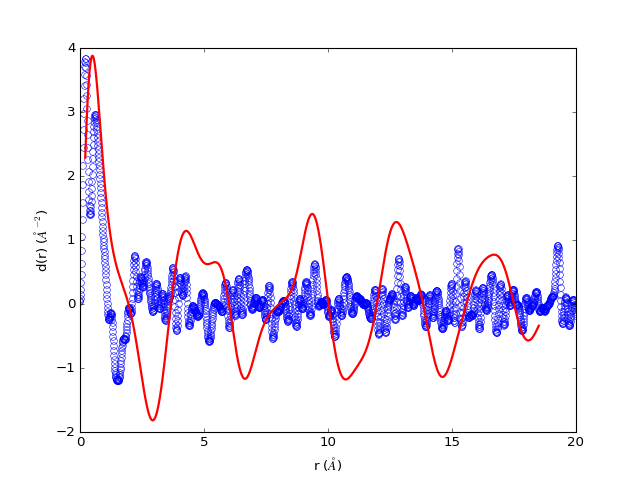

In [5]:
### Do some pure calculations

### Extract and save the experimental mPDF from the exported PDF fit file
inPrefix='x00y015/mPDF/exportedPDFfits/I4mmm_0-20_'
inSuffix='K.fgr'
outPrefix='x00y015/mPDF/exportedPDFfits/I4mmm_0-20_'
outSuffix='_scaleNorm.diff'
tempStrings=['002','030','150','300']

temps,scaleFactors=np.loadtxt('x00y015/mPDF/exportedPDFfits/qmax31lorch_I4mmm_Tscan_scale.dat',unpack=True)

### Set some important values for calculation and structure
rstep=0.01
rmin=0.2 # rmin and rmax set the data range for the fit
rmax=18.5
rcalcmin = 0 # The calculation is extended slightly beyond the fit range to avoid artifacts at boundaries.
rcalcmax=20

qmin,qmax=0.0,31.41

[dq,q1,q2] = [0.01,0.00,10.00]
q=np.arange(q1,q2,dq)   
ffMag=j0calc(q,[0.422,17.684,0.5948,6.005,0.0043,-0.609,-0.0219]) ### magnetic form factor for Ni2+

r1,r2,dr=-5.0,5.0,0.01
rsr, sr=costransform(q,ffMag,rmin=r1,rmax=r2,rstep=dr)
sr = np.sqrt(np.pi/2.0)*sr

rSr,Sr = cv(rsr,sr,rsr,sr)

para = -1.0*np.sqrt(2.0*np.pi)*np.gradient(Sr,rSr[1]-rSr[0]) ### paramagnetic term in d(r)

### Prepare the tetragonal structure for the calculations

### lattice parameters of magnetic unit cell, and some basis transformation stuff
e1=np.array([1,0,0])
e1n=e1/np.linalg.norm(e1)
e2=np.array([0,1,0])
e2n=e2/np.linalg.norm(e2)
e3=np.array([0,0,1])
e3n=e3/np.linalg.norm(e3)

temps,aVals=np.loadtxt('x00y015/mPDF/exportedPDFfits/qmax31lorch_I4mmm_Tscan_a-lat.dat',unpack=True)
temps,cVals=np.loadtxt('x00y015/mPDF/exportedPDFfits/qmax31lorch_I4mmm_Tscan_c-lat.dat',unpack=True)

Basis=np.array([e1,e2,e3])
IBasis=np.linalg.inv(Basis)
BasisN=np.array([e1n,e2n,e3n])

### positions of atoms in magnetic unit cell
basis=np.array([[0.5,0,0.75],[0,0.5,0.75],[0.5,0,0.25],[0,0.5,0.25]])

scaleParas=np.zeros_like(temps)
scaleCorrs=np.zeros_like(temps)
thetas=np.zeros_like(temps)
phis=np.zeros_like(temps)
damps=np.zeros_like(temps)
widths=np.zeros_like(temps)
chisqs=np.zeros_like(temps)
### loop through the temperatures to do the refinements
i=0
a=aVals[i]
b=aVals[i]
c=cVals[i]    
latpars=np.array([[a],[b],[c]])
full=BasisN*latpars
cell=np.dot(IBasis,full)
atomcell=np.dot(basis,cell)

### spin orientations in same order as atomic positions.
svec=np.array([0.0,0.0,1])
svec=svec/np.linalg.norm(svec)
svecmag=np.sqrt((svec*svec).sum())
theta0=np.arccos(svec[2]/svecmag)
phi0=np.arctan2(svec[1],svec[0])
S=2.5

### how big to make the box
radius=1.5*rcalcmax
dim1=np.round(radius/np.linalg.norm(cell[0]))
dim2=np.round(radius/np.linalg.norm(cell[1]))
dim3=np.round(radius/np.linalg.norm(cell[2]))

### generate the coordinates of each unit cell 
latos=np.dot(np.mgrid[-dim1:dim1+1,-dim2:dim2+1,-dim3:dim3+1].transpose().ravel().reshape((2*dim1+1)*(2*dim2+1)*(2*dim3+1),3),cell)

### select points within a desired radius from origin
latos=latos[np.where(np.apply_along_axis(np.linalg.norm,1,latos)<=(rcalcmax+10.0))]

## rearrange latos array so that [0,0,0] is the first one (for convenience)
latos[np.where(np.all(latos==[0,0,0],axis=1))]=latos[0]
latos[0]=np.array([0,0,0])

### create list of all atomic positions and spin directions
atoms=np.empty([len(latos)*len(atomcell),3])
index=0
for k in range(len(latos)):
    for j in range(len(atomcell)):
        atoms[index]=latos[k]+atomcell[j]
        index+=1

### create spins using propagation vector
astar,bstar,cstar=getRlat(cell[0],cell[1],cell[2])
Q=0.0*astar+1.0*bstar+1.0*cstar
signs=np.cos(np.dot(atoms-atoms[0],Q))
spins=S*svec*signs.reshape(-1,1)

### Perform the calculations.

uclist=np.arange(1) # indices of atoms which will be used as centers in the mPDF calculation
x=np.array([0]) # empty array to be used as placeholder in the calculations

dataFileName=outPrefix+tempStrings[i]+outSuffix
expr,expDr = np.loadtxt(dataFileName,unpack=True) # grab the experimental data.
data=expDr[np.logical_and(expr>rmin+0.5*rstep,expr<=rmax+0.5*rstep)]
rcomp = expr[np.logical_and(expr>rmin+0.5*rstep,expr<=rmax+0.5*rstep)]

print 'Calculating...'

scaleCorr,scalePara=0.075,0.35
theta,phi=theta0,phi0
width,damp=0.2,10

calcDr,rfr,fr=fitfuncAF(x,rmin,rmax,scaleCorr,scalePara,theta,phi,width,damp,rSr,Sr,para,Q,atoms)
fig=plt.figure()
ax=fig.add_subplot(111)
ax.plot(expr,expDr,marker='o',mfc='none',mec='b',linestyle='none')
ax.plot(rcomp,calcDr,'r-',lw=2)
#ax.plot(rfr,fr,'k-')
#ax.plot(r,fr,'b-')
ax.set_xlim(xmin=rcalcmin,xmax=rcalcmax)
ax.set_xlabel('r ($\AA$)')
ax.set_ylabel('d(r) ($\AA^{-2}$)')

In [6]:
plt.close('all')

In [7]:
astar

array([ 1.52661235,  0.        ,  0.        ])

So we see that the standard AF pattern does not work at all; that first nearest neighbor peak really does seem to be ferromagnetic.

## Now we will plot the S(Q) data just for fun

<IPython.core.display.Javascript object>


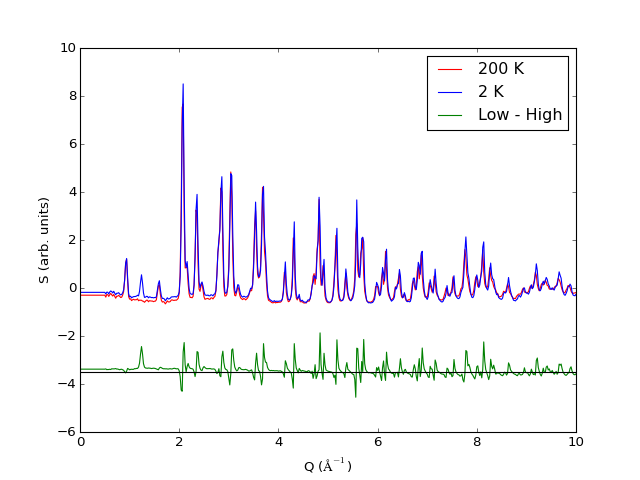

In [22]:
### Do some pure calculations

### Extract and save the experimental mPDF from the exported PDF fit file
inPrefix='SQfiles/NOM_9999_Ba122K02Mn015_'
inSuffix='K_SQ.dat'
tempStrings=['300','250','200','150','130','100','50','2']

#temps,scaleFactors=np.loadtxt('x00y015/mPDF/exportedPDFfits/qmax31lorch_I4mmm_Tscan_scale.dat',unpack=True)


qmin,qmax=0.0,10

fig=plt.figure()
ax=fig.add_subplot(111)

#q300,sq300,sqerr300=np.loadtxt(inPrefix+tempStrings[0]+inSuffix,unpack=True)
#for i in [2,7]:
#    dataFileName=inPrefix+tempStrings[i]+inSuffix
#    q,sq,sqerr=np.loadtxt(dataFileName,unpack=True)
#    ax.plot(q,sq,label=tempStrings[i],linestyle='-')

q200,sq200,sqerr200=np.loadtxt(inPrefix+tempStrings[2]+inSuffix,unpack=True)
q2,sq2,sqerr2=np.loadtxt(inPrefix+tempStrings[7]+inSuffix,unpack=True)

ax.plot(q200,sq200,label='200 K',color='r',linestyle='-')
ax.plot(q,sq2,label='2 K',color='b',linestyle='-')
ax.plot(q,sq2-sq200-3.5,label='Low - High',color='g',linestyle='-')
ax.plot(q,np.zeros_like(q)-3.5,'k-')

plt.legend(loc=0)
ax.set_xlim(xmin=qmin,xmax=qmax)
ax.set_xlabel('Q ($\AA^{-1}$)')
ax.set_ylabel('S (arb. units)')

plt.savefig('sqdata.png',format='PNG',dpi=150,bbox_inches='tight')

In [20]:
plt.close('all')